# Install package

In [1]:
# install community
# library(devtools)

# devtools::install_github("SoloveyMaria/community")

# Calculate communication

In [65]:
# libraries
library(community)
require(ggplot2)
require(gridExtra)
require(grid)
require(ComplexHeatmap)
require(dendsort)
require(igraph)
require(circlize)
require(R.utils)
require(data.table) #to read gz file
require(org.Hs.eg.db)
require(clusterProfiler)

Loading required package: clusterProfiler



clusterProfiler v4.6.0  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:igraph’:

    simplify


The following object is masked from ‘package:stats’:

    filter




In [3]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- getwd()

print("path_in")
print(path_in)

[1] "path_in"
[1] "/work/project/ladcol_011/clean_community/community/docs/showcase_notebooks/Lasry"


In [4]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/mcelik/miniconda3/envs/community_tutorial/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_DE.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=de_DE.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=de_DE.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_DE.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] data.table_1.14.8     R.utils_2.12.2        R.oo_1.25.0          
 [4] R.methodsS3_1.8.2     circlize_0.4.15       igraph_1.4.0         
 [7] dendsort_0.3.4        ComplexHeatmap_2.14.0 gridExtra_2.3        
[10] ggplot2_3.4.1         community_1.2.8      

loaded via a

## Load data

**Note:** Running this notebook takes around 15 minutes depending on your hardware configration. If you'd like to skip computing the results, please load `interactions.RData` file.

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [5]:
data("LR_database")
print(str(LR_database))

'data.frame':	6857 obs. of  26 variables:
 $ Pair.Name            : chr  "ADAM10_AXL" "ADAM10_EPHA3" "ADAM12_ITGB1" "ADAM12_SDC4" ...
 $ Ligand               : chr  "ADAM10" "ADAM10" "ADAM12" "ADAM12" ...
 $ Ligand.Name          : chr  "ADAM metallopeptidase domain 10" "ADAM metallopeptidase domain 10" "ADAM metallopeptidase domain 12" "ADAM metallopeptidase domain 12" ...
 $ Receptor             : chr  "AXL" "EPHA3" "ITGB1" "SDC4" ...
 $ Receptor.Name        : chr  "AXL receptor tyrosine kinase" "EPH receptor A3" "integrin subunit beta 1" "syndecan 4" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ partner_a            : chr  "O14672" "O14672" "O43184" "O43184" ...
 $ partner_b            : chr  "P30530" "P29320" "P05556" "P31431" ...
 $ source               : chr  "O14672" "O14672" "O43184" "O43184" ...
 $ target               : chr  "P30530" "P29320" "P05556" "P31431" ...
 $ source_genesymbol    : chr  "ADAM10" "ADAM10" "ADAM12" "ADAM12" ...
 $ target_genesymbol    : chr  "AXL

In [6]:
# # load counts
print("load counts")
counts <- fread("input_data_from_zenodo/counts_corr.csv.gz", header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	15770 obs. of  46702 variables:
 $ 2020.09.15.AML0024.CATCAAGGTTAGCGGA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CATCAAGTCCGAGAAG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CATCCACAGGGACCAT           : num  0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACAGAGCAAGA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACAGTTCCATG           : num  0 0.69 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACGTAGAATAC           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACGTTCTCCCA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACTCCGAACGC           : num  0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCAACTCTAGTCAG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACAAGACAGTCG           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACACAATTGCCA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 2020.09.15.AML0024.CCTCACACAGAACTAA           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ 

In [7]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table("input_data_from_zenodo/anno_cells_corr.txt"
                         ,sep = "\t"
                         ,row.names = 1
                         ,header = TRUE
                         )
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	46702 obs. of  93 variables:
 $ sample_ID                    : chr  "AML-0024" "AML-0024" "AML-0024" "AML-0024" ...
 $ cell                         : chr  "2020-09-15-AML0024:CATCAAGGTTAGCGGA" "2020-09-15-AML0024:CATCAAGTCCGAGAAG" "2020-09-15-AML0024:CATCCACAGGGACCAT" "2020-09-15-AML0024:CCTCAACAGAGCAAGA" ...
 $ UMAP_1                       : num  -0.731 -2.2 -2.867 -1.666 -0.972 ...
 $ UMAP_2                       : num  -15.8 -16.7 -16.1 -16.1 -17.5 ...
 $ orig.ident                   : chr  "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" "2020-09-15-AML0024" ...
 $ samples                      : chr  "AML0024" "AML0024" "AML0024" "AML0024" ...
 $ Broad_cell_identity          : chr  "CD14+ monocyte" "CD14+ monocyte" "CD16+ monocyte" "CD14+ monocyte" ...
 $ Cell_type_identity           : chr  "CD14+ IFN+" "CD14+" "CD16+" "CD14+ IFN+" ...
 $ clusters_res.2               : int  7 7 7 7 80 7 7 7 7 7 ...
 $ CNV_pos                   

In [8]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table("input_data_from_zenodo/anno_samples_corr.txt"
                           ,sep = "\t"
                           ,row.names = 1
                           ,header = TRUE
                           )
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	13 obs. of  60 variables:
 $ Sample.ID                    : chr  "U-06-0024" "U-16-0160" "U-11-0693" "U-18-1371" ...
 $ sex                          : chr  "M" "M" "F" "M" ...
 $ Age                          : int  64 74 77 78 71 57 80 26 39 50 ...
 $ Sequencing                   : chr  "CITE-seq" "CITE-seq" "CITE-seq + scTCR-seq" "CITE-seq" ...
 $ sample_ID                    : chr  "AML-0024" "AML-0160" "AML-0693" "AML-1371" ...
 $ Institution                  : chr  "OSU" "OSU" "OSU" "OSU" ...
 $ Manuscript.ID                : chr  "AML0024" "AML0160" "AML0693" "AML1371" ...
 $ Dx                           : chr  "AML" "AML" "AML" "AML" ...
 $ DxELN_Cytogenetic            : chr  "Adverse" "Adverse" "Adverse" "" ...
 $ Cytogenetics                 : chr  "48,XY,+8,+8,i(8)(p10),t(9;15)(q33;q15),del(10)(q22.1q24),del(13)(q14q21)" "46,XY[30]" "74-89<4n>,XXXX,-8,-9,-9,-12,-17,i(17)(q10),+mar1,+mar2,+dmin[cp18]/46,XX[2] .ish dmin(amp CMYC)" "46,X

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The deafult value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.05.

In [9]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [10]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [11]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [12]:
# Renaming the cell_ID.1 column in anno_cells to "cell_ID"
colnames(anno_cells)[colnames(anno_cells) == "cell_ID.1"] <- "cell_ID"

In [13]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-0160 does not contain cell type NK -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-2123 does not contain cell type DC -- interactions for this cell type in this sample will get zero values.”
Warning message in e_cellType_gene(counts = counts_sub, anno_cells = anno_cells_sub, :
“WARNING: sample AML-4340 does not contain cell type Ery -- interactions for this cell type in this sample will get zero values.”


## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [14]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	148608 obs. of  19 variables:
 $ interaction_ID     : chr  "Mono:ADAM10_Mono:AXL" "Mono:ADAM12_Mono:ITGB1" "Mono:ADAM12_Mono:SDC4" "Mono:ADAM15_Mono:ITGA5" ...
 $ ligand_gene_name   : chr  "ADAM10" "ADAM12" "ADAM12" "ADAM15" ...
 $ receptor_gene_name : chr  "AXL" "ITGB1" "SDC4" "ITGA5" ...
 $ sending_cell_type  : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_type: chr  "Mono" "Mono" "Mono" "Mono" ...
 $ mean_e_s_l_control : num  0.804 0.498 0.498 0.796 0.796 ...
 $ mean_e_s_l_case    : num  0.775 0.336 0.336 0.749 0.749 ...
 $ mean_e_r_r_control : num  0.496 0.855 0.762 0.802 0.625 ...
 $ mean_e_r_r_case    : num  0.3 0.849 0.691 0.778 0.579 ...
 $ log2FC_rho_s       : num  -0.455 -0.455 -0.455 -0.455 -0.455 ...
 $ log2FC_rho_r       : num  -0.455 -0.455 -0.455 -0.455 -0.455 ...
 $ log2FC_rho         : num  0.145 0.145 0.145 0.145 0.145 ...
 $ log2FC_phi_s_l     : num  0.288 7.419 7.419 0.414 0.414 ...
 $ log2FC_phi_r_r     : nu

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [15]:
threshold_log10_cum_weight <-  0.01
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.01


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [16]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [17]:
threshold_log10_meanexpr_per_condition <- 0.02
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.02


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


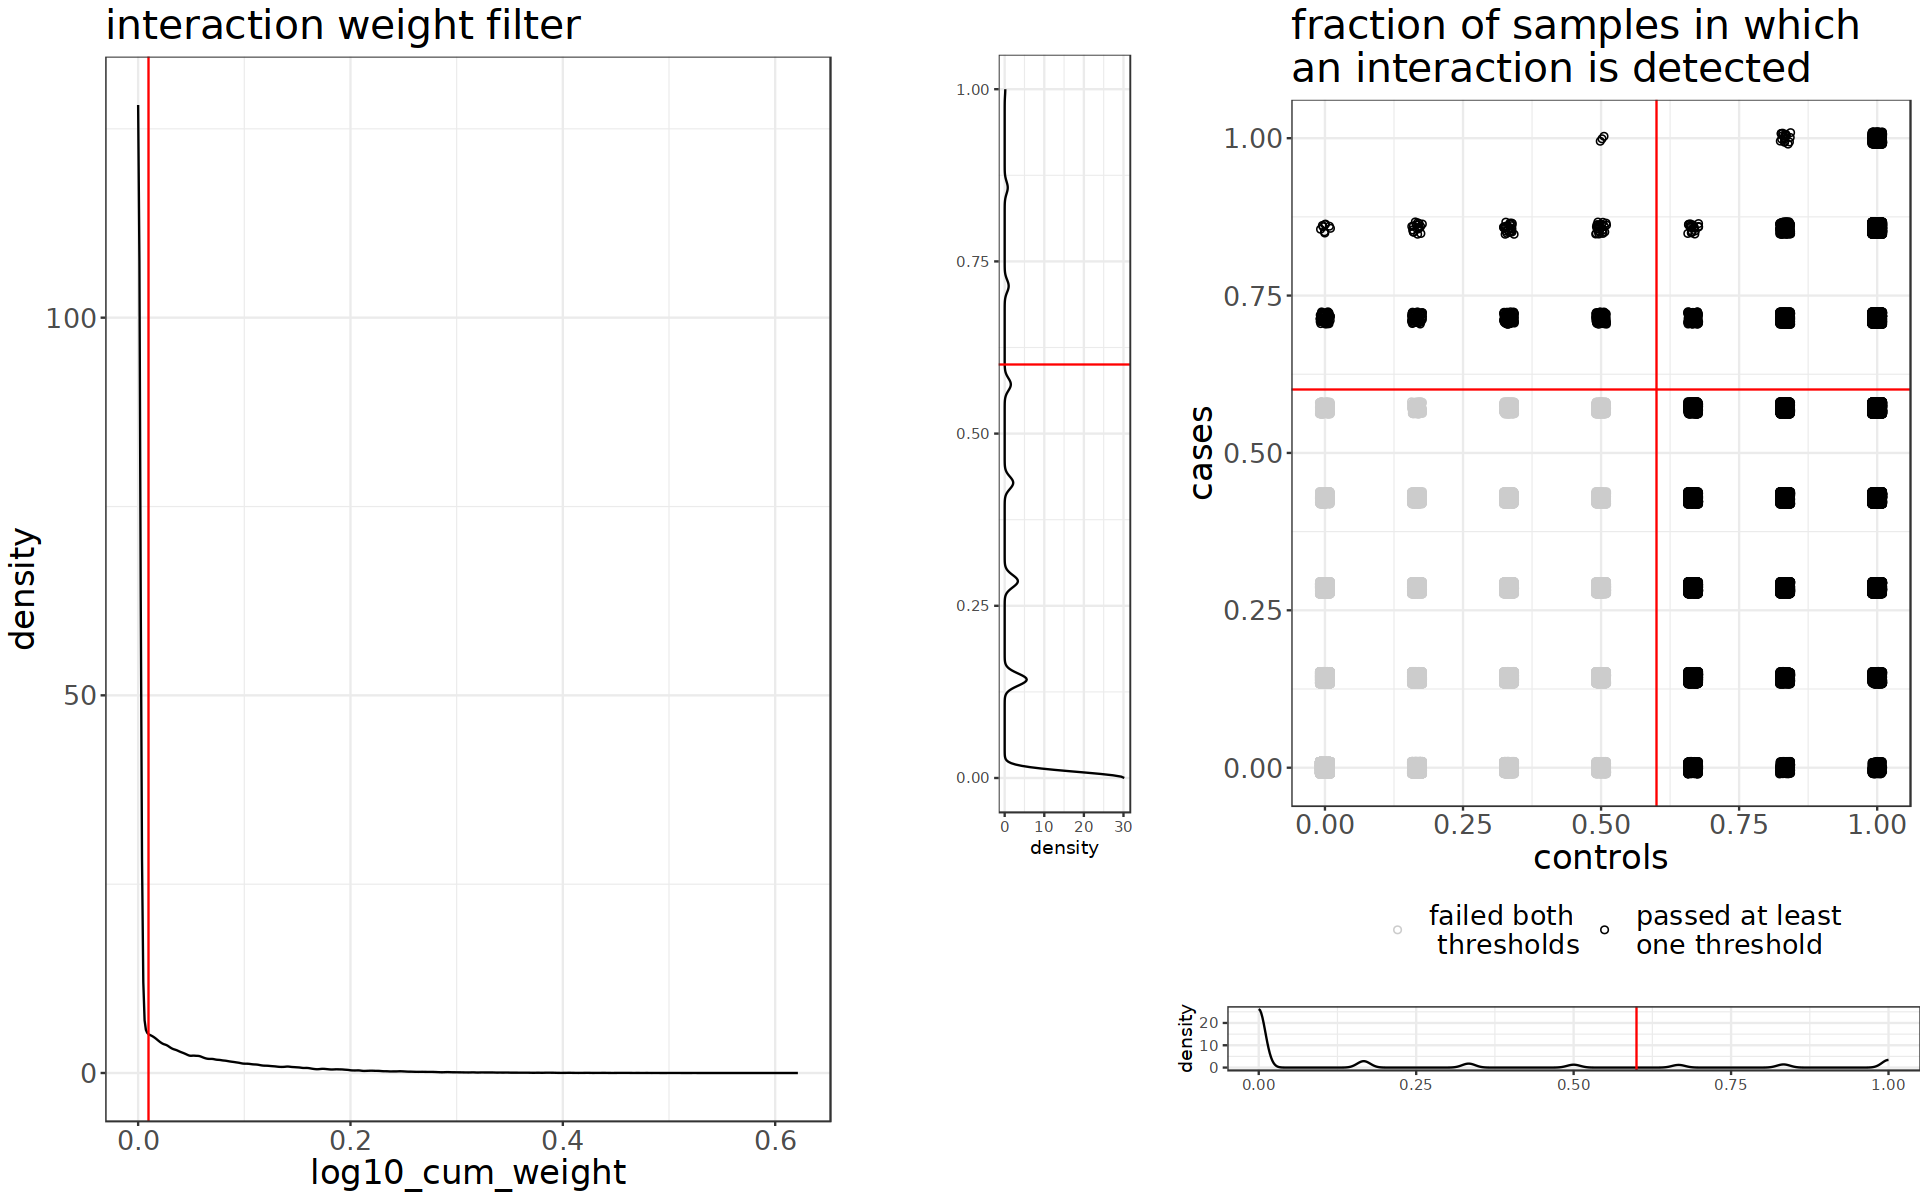

[1] "125776 out of 148608 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.01 and fraction of expressing samples > 0.6 . Also  11667  interactions didn't pass the discrepancy filter.  In total, 125776  bad quality interactions will be removed and 22832 good quality interactions will remain."


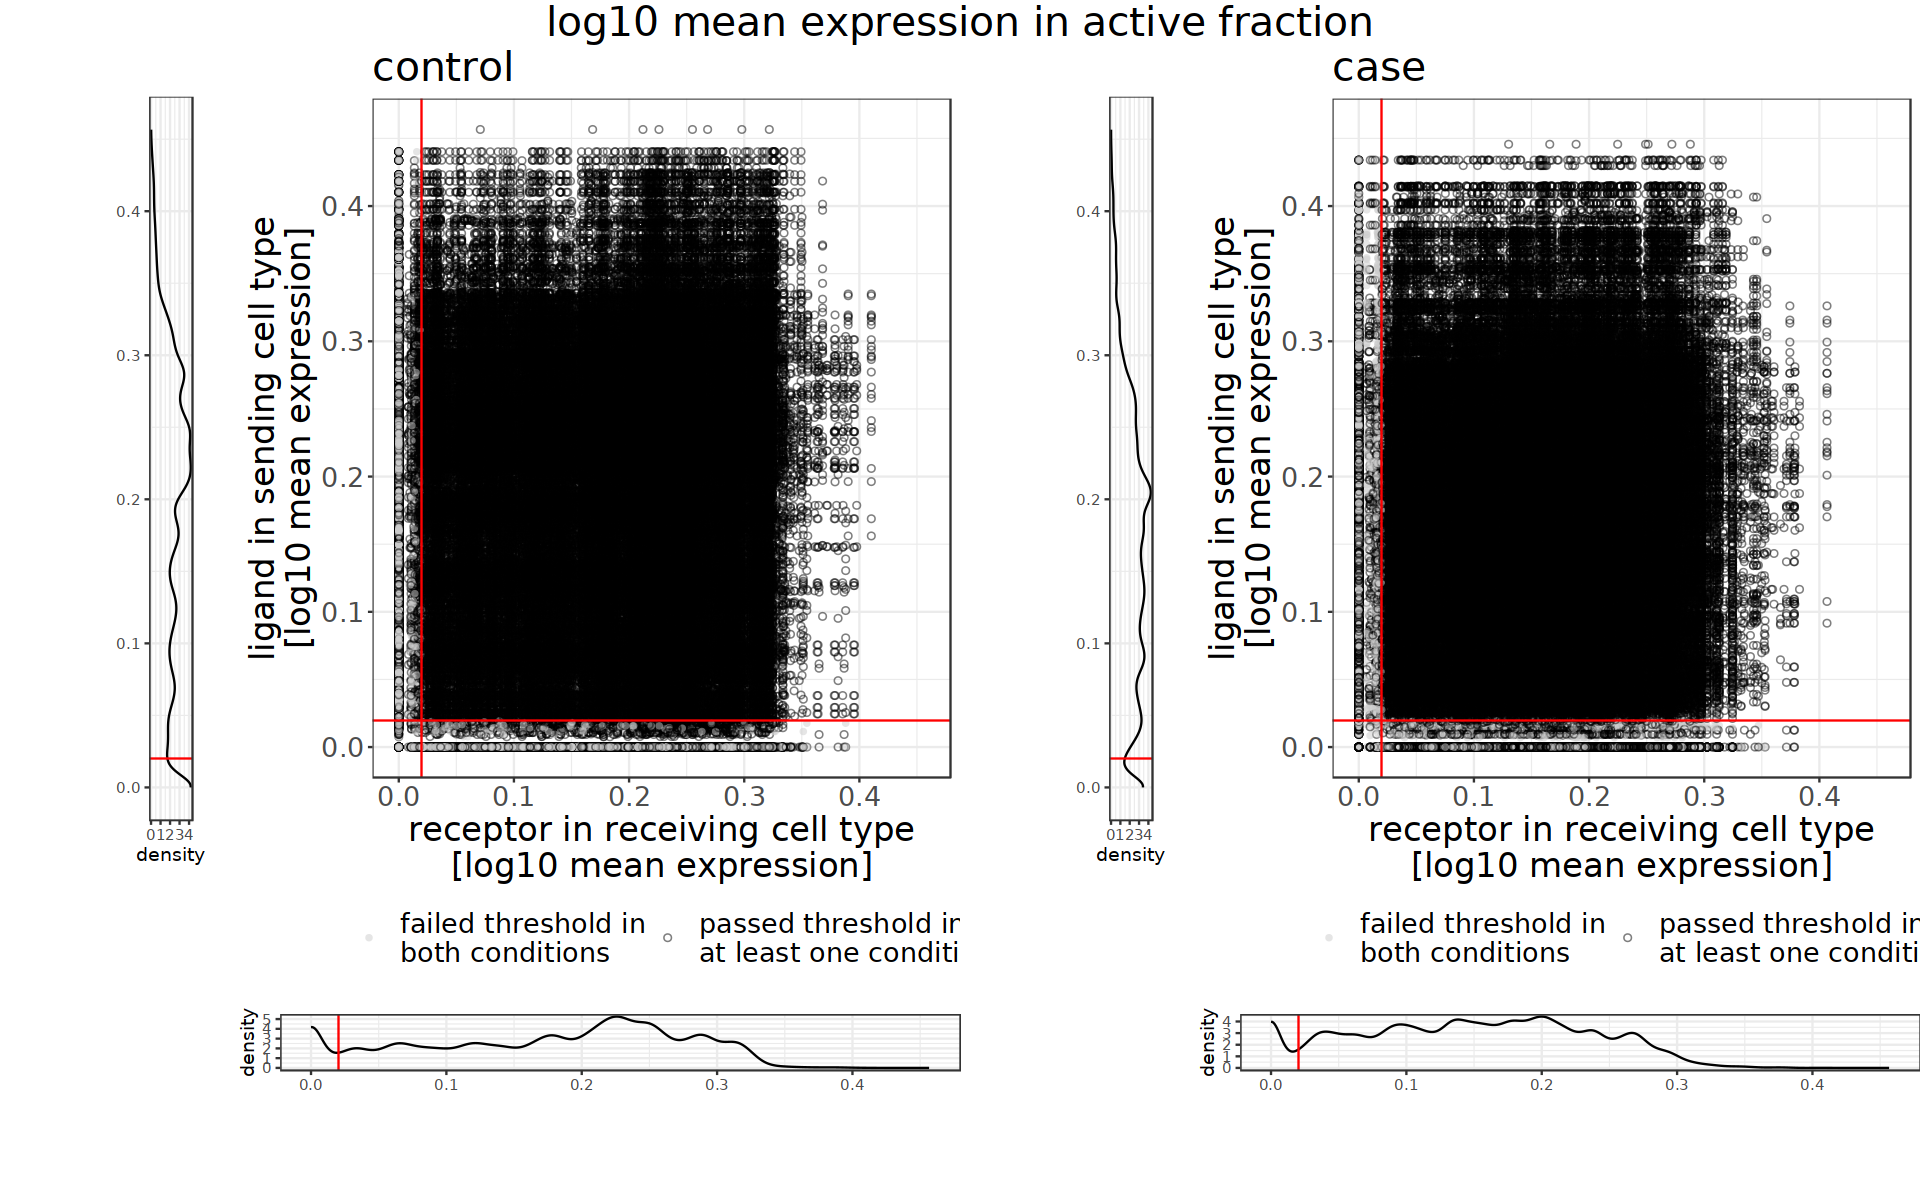

In [18]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [19]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
NULL
'data.frame':	148608 obs. of  28 variables:
 $ interaction_ID                            : chr  "Mono:ADAM10_Mono:AXL" "Mono:ADAM12_Mono:ITGB1" "Mono:ADAM12_Mono:SDC4" "Mono:ADAM15_Mono:ITGA5" ...
 $ ligand_gene_name                          : chr  "ADAM10" "ADAM12" "ADAM12" "ADAM15" ...
 $ receptor_gene_name                        : chr  "AXL" "ITGB1" "SDC4" "ITGA5" ...
 $ sending_cell_type                         : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_type                       : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ mean_e_s_l_control                        : num  0.804 0.498 0.498 0.796 0.796 ...
 $ mean_e_s_l_case                           : num  0

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [20]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [21]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [22]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 2744 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.02
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	148608 obs. of  33 variables:
 $ interaction_ID                            : chr  "Mono:ADAM10_Mono:AXL" "Mono:ADAM12_Mono:ITGB1" "Mono:ADAM12_Mono:SDC4" "Mono:ADAM15_Mono:ITGA5" ...
 $ ligand_gene_name                          : chr  "ADAM10" "ADAM12" "ADAM12" "ADAM15" ...
 $ receptor_gene_name                        : chr  "AXL" "ITGB1" "SDC4" "ITGA5" ...
 $ sending_cell_type                         : chr  "Mono" "Mono" "Mono" "Mono" ...
 $ receiving_cell_typ

# Visualisation

In [23]:
idx_up <- interactions$anno_interactions$log2FC_weights >1
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
idx_down <- interactions$anno_interactions$log2FC_weights < -1
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [24]:
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Mono" "Gran" "T"    "NK"   "B"    "HSPC" "Ery"  "DC"  


### Mean weight of good quality edges

In [27]:
# dir.create("/figures")

            Mono        Gran           T          NK           B       HSPC
Mono 0.043616540 0.040734857 0.010914299 0.009137404 0.004835338 0.01145834
Gran 0.041776927 0.054880069 0.016225021 0.011304203 0.018576338 0.02799924
T    0.011881390 0.012761657 0.092610163 0.078294734 0.021953710 0.02823177
NK   0.009512074 0.008632324 0.078149721 0.075080882 0.014492476 0.01795082
B    0.005698152 0.018138236 0.023668176 0.015781084 0.019446318 0.02484106
HSPC 0.011430938 0.027957088 0.029807622 0.018717305 0.025474552 0.04862390
Ery  0.001319146 0.005653941 0.009493777 0.002793339 0.008416497 0.02197271
DC   0.012884136 0.019289297 0.032835978 0.029983129 0.007470901 0.01198462
              Ery           DC
Mono 0.0011516750 0.0112460260
Gran 0.0056766440 0.0165797407
T    0.0081893538 0.0280186230
NK   0.0028292450 0.0248128689
B    0.0076582014 0.0063615801
HSPC 0.0219159232 0.0098836448
Ery  0.0138861480 0.0005007446
DC   0.0006770067 0.0209757902


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


            Mono        Gran           T          NK           B        HSPC
Mono 0.029902852 0.043132261 0.025757214 0.022058004 0.027811590 0.006853631
Gran 0.047278645 0.078956634 0.038656872 0.028495154 0.047513186 0.011917719
T    0.023697987 0.034256262 0.035461312 0.022736420 0.031886854 0.005611854
NK   0.021029247 0.026777843 0.023387219 0.018708684 0.018263027 0.004637668
B    0.027031161 0.042779872 0.034656534 0.019749390 0.054017964 0.006538474
HSPC 0.007519033 0.012100729 0.006900497 0.005103904 0.007750737 0.001647948
Ery  0.006664024 0.007857356 0.003767848 0.004222751 0.005657401 0.001199431
DC   0.048386312 0.068003120 0.037665463 0.032494046 0.040590479 0.011012824
             Ery          DC
Mono 0.006697844 0.043573447
Gran 0.008352396 0.067084294
T    0.003533478 0.032639602
NK   0.004255899 0.029768513
B    0.005406935 0.037367318
HSPC 0.001185860 0.011111653
Ery  0.001272197 0.008263703
DC   0.008235042 0.069288449


Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

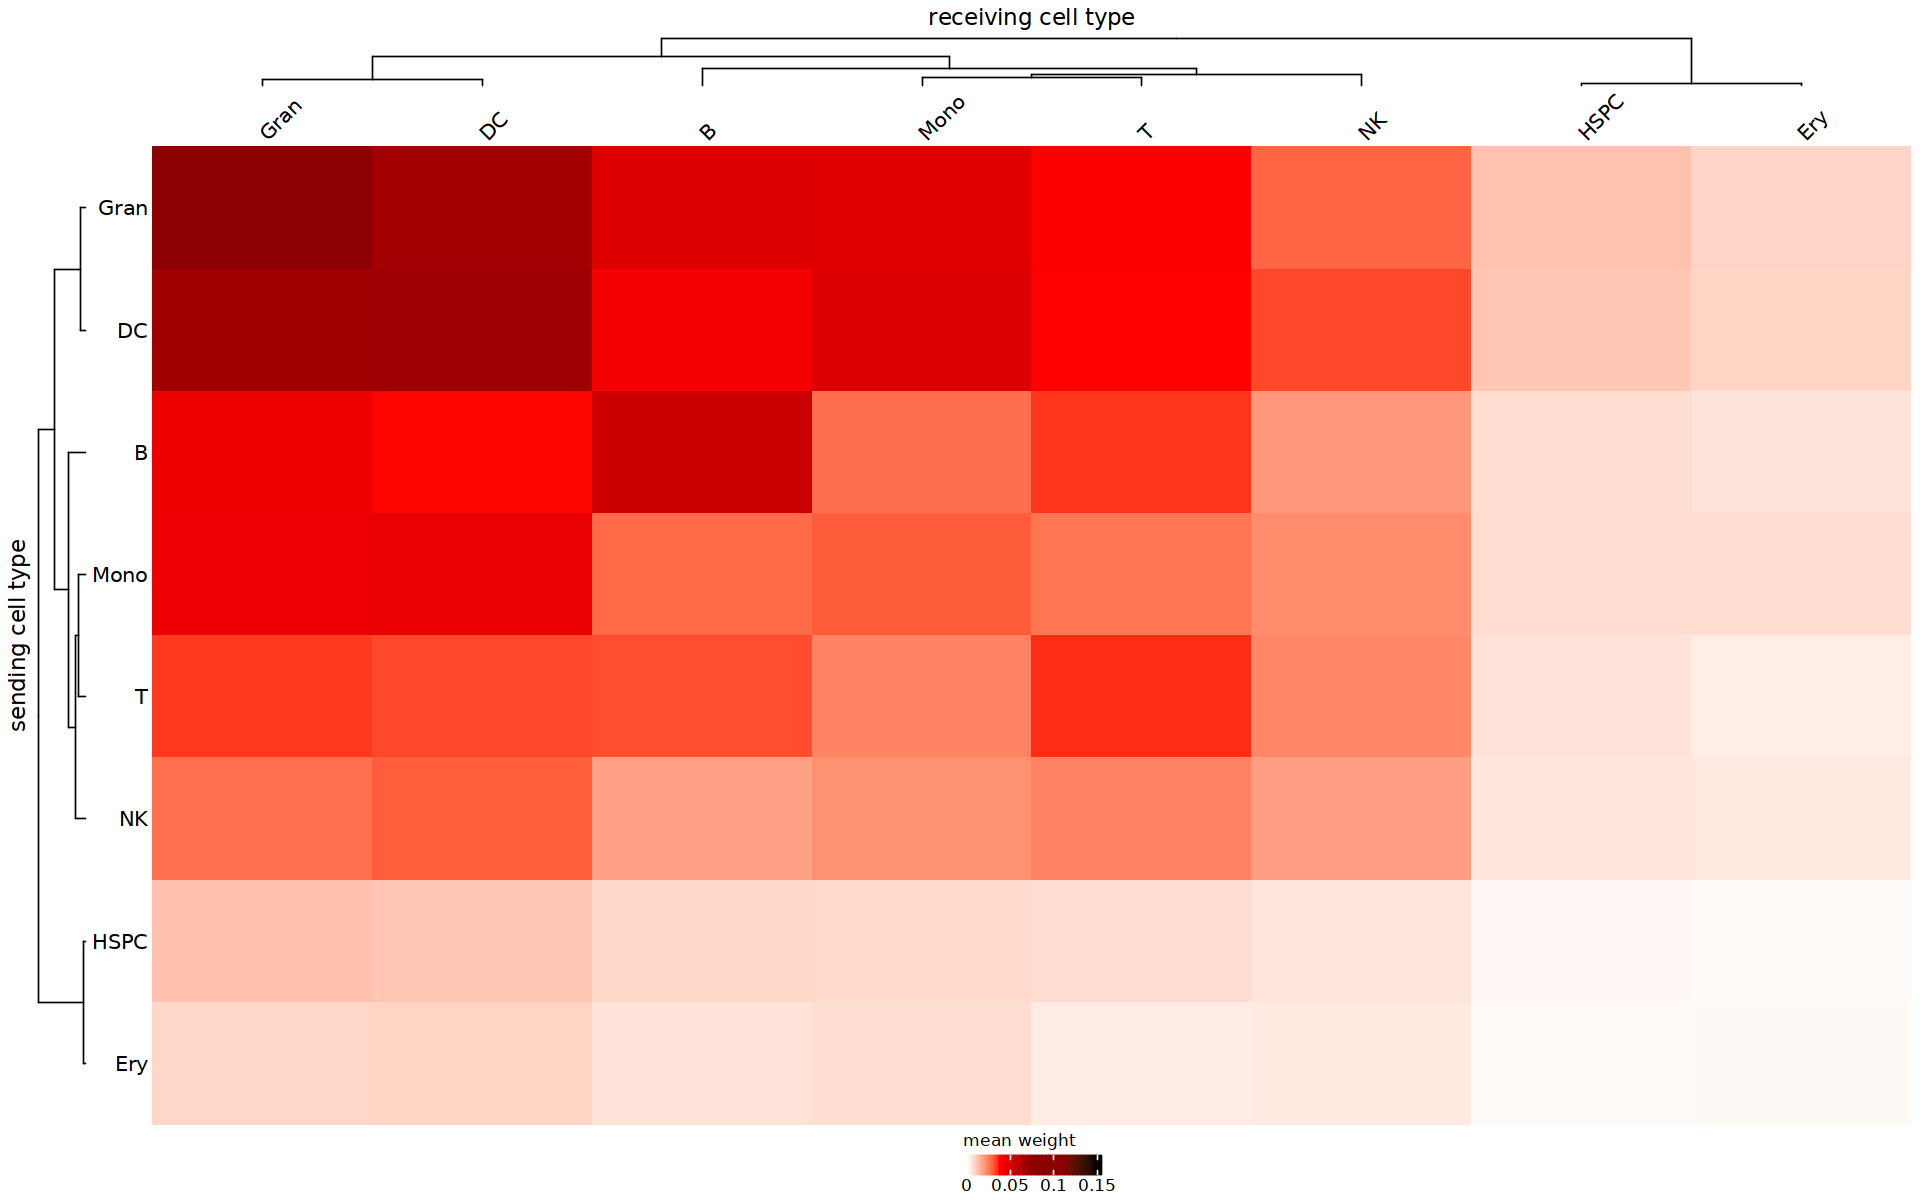

In [28]:
# heatmap of total weight of good interactions
lapply(c("AML","healthy")
      ,function(hs){
          
          idx_hs <- interactions$anno_samples$health_status == hs
          
          # number of interactions as heatmap
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types

    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send

        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec

            #print(send)
            #print(rec)
            #print(head(interactions$anno_interactions[idx_good & idx_send & idx_rec,c("interaction_ID"
            #                                                                          ,"log2FC_weights"
            #                                                                          , "sign")]))
            #print(sum(idx_good & idx_send & idx_rec))

            weights <- interactions$weights[idx_good & idx_send & idx_rec,idx_hs]
            #ifelse(length(weights) == 0
            #      ,df[send,rec] <- 0
                 # ,
            df[send,rec] <- mean(unlist(weights))
             #     )
            

        }
    }

    print(df)

    my_color <-  colorRamp2(seq(0
                                , 0.15 #max(df)
                                , length = 5)
                            , c("white", "red", "red4",  "darkred", "black"))

    h <- Heatmap(df
                 ,name = "mean weight"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                 ,column_title = "receiving cell type"
                 ,row_title = "sending cell type"
                 #,cluster_columns=FALSE
                 #,cluster_rows=FALSE
                 #,row_order = c("HSPC", "DC", "Mono", "Ery", "B", "T")
                 #,column_order = c("HSPC","DC", "Mono", "Ery", "B", "T")
                 ,column_names_rot = 45
                )
          ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")

    pdf(file=paste0("figures/heatmap_cellTypes_meanWeight_"
                    ,hs
                    ,".pdf"))
         ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")
           dev.off()
      })

### Volcano plot

We can now visualize the interactions with a volcano plot. 

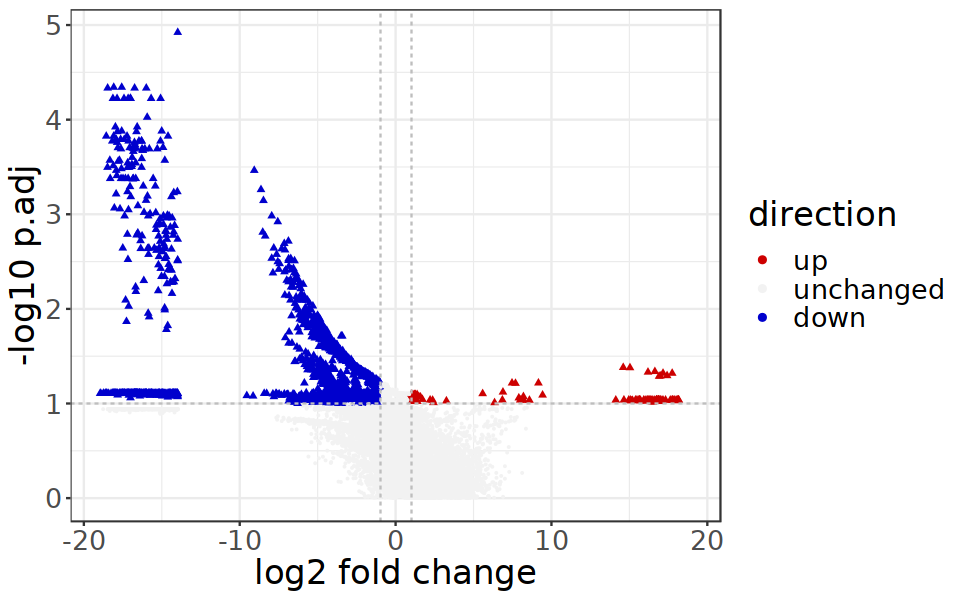

In [29]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 8)

df <- data.frame(log2FC = interactions$anno_interactions$log2FC_weights[idx_good]
                 ,y = -log10(interactions$anno_interactions$p.adj[idx_good])
                 ,significant = interactions$anno_interactions$sign[idx_good]
                )

df$direction <- "unchanged"
df$direction[df$significant & (df$log2FC > 1)] <- "up"
df$direction[df$significant & (df$log2FC < -1)] <- "down"
df$direction <- factor(df$direction
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                      ,ordered = TRUE)

xlab <- "log2 fold change"
ylab <- "-log10 p.adj"

xlim <- c(-max(abs(df$log2FC))
          ,max(abs(df$log2FC))
         )
ylim <- c(0, max(df$y))

p <- ggplot(data = df
            ,aes(x = log2FC
                 ,y = y
                 ,color = direction
                 ,size = significant
                 ,shape = significant
                ))+
geom_point()+
scale_color_manual(values = c("red3"
                               ,"gray95"
                               ,"blue3"))+
scale_size_manual(values = c(0.5, 1.5))+
guides(size = "none"
      ,shape = "none")+
xlab(xlab)+
ylab(ylab)+
xlim( xlim )+
ylim(ylim)+
theme_bw()+
theme(text = element_text(size=20))+
geom_vline(xintercept = interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_vline(xintercept = -interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_hline(yintercept = -log10(interactions$thresholds$threshold_fdr)
          ,lty = 2
          ,color = "gray")
p




   up unchanged down
1 109     20088 2635


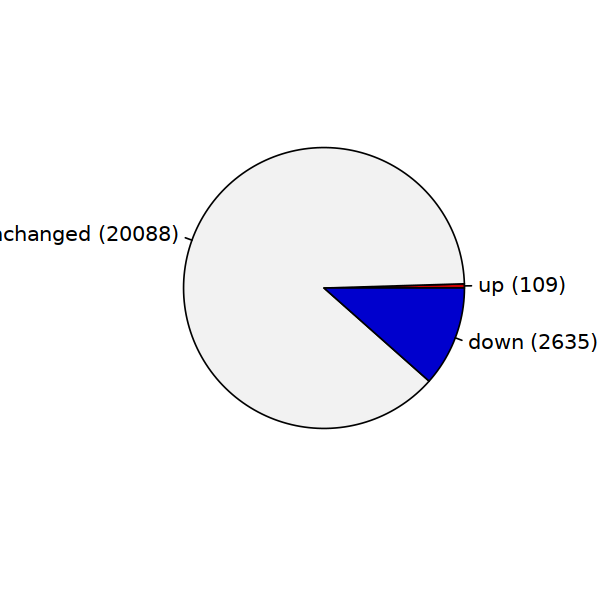

In [30]:
# pie chart
df <- data.frame(up = sum(idx_good & idx_sign & idx_up)
                ,unchanged = sum(idx_good & !idx_sign)
                , down = sum(idx_good & idx_sign & idx_down)
                )
print(df)

options(repr.plot.width = 5
       ,repr.plot.height = 5)
pie(unlist(df)
   ,labels = paste0(colnames(df)," (",unlist(df), ")")
   ,col = c("red3"
           ,"gray95"
           ,"blue3")) 

### Heatmap of top differential interactions

In [31]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
# all upregulated interactions
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign

# top 20 downregulated interactions
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown20 <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:20]

idx <- idx_topup | idx_topdown20
print(sum(idx))

[1] 31


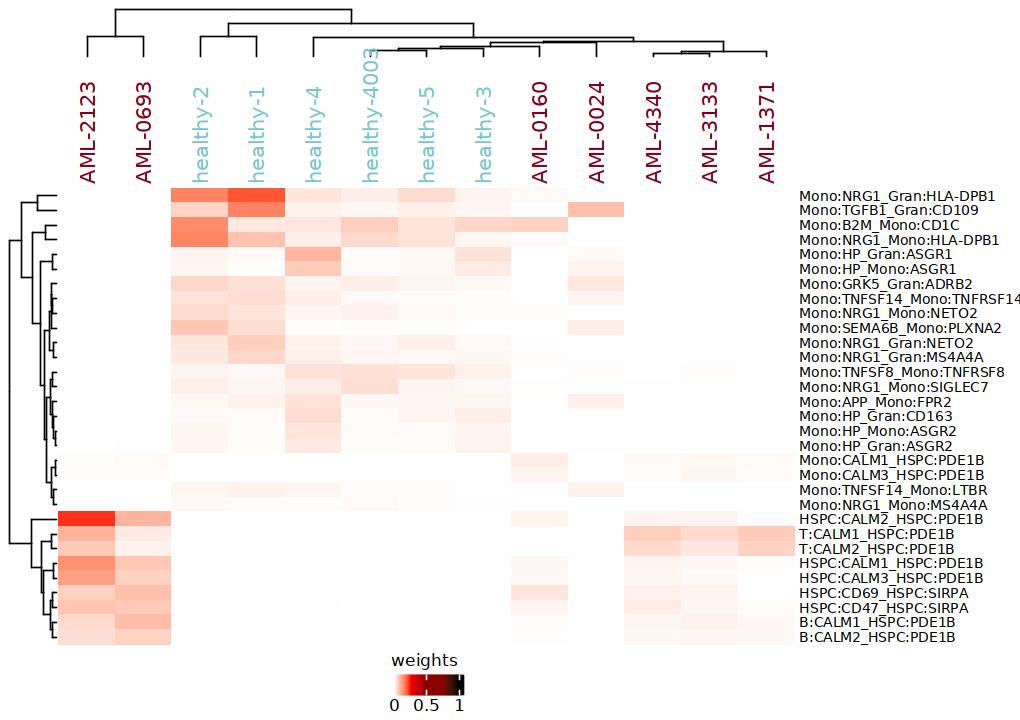

In [32]:
set.seed(1)
options(repr.plot.height = 6
       ,repr.plot.width = 8.5)
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights")

#### Individual parameters

  cell_type  log2FC_rho
6      HSPC  2.17786184
7       Ery  1.68004637
3         T  0.16795948
4        NK  0.05044305
1      Mono -0.45469947
2      Gran -0.51086488
5         B -0.67813612
8        DC -1.37836811


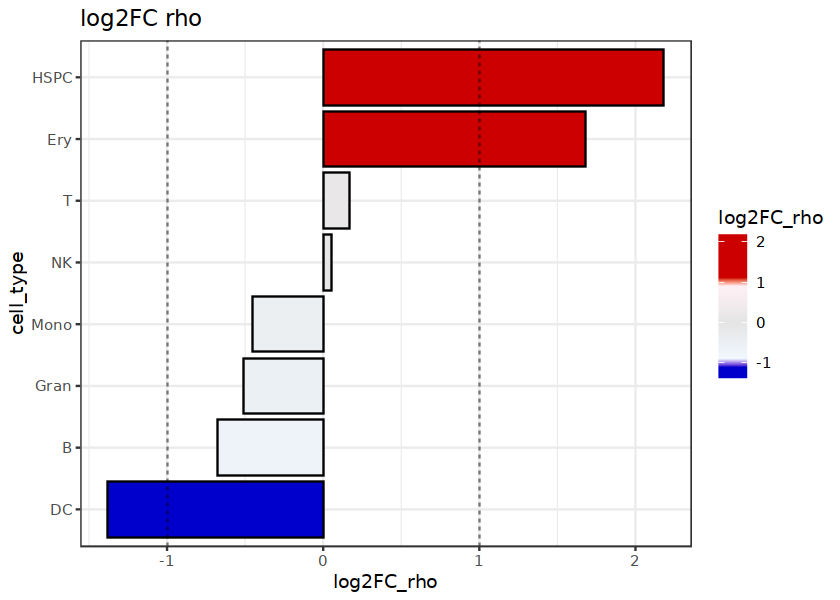

In [33]:
# plot log2FC rho for cell types
df <- data.frame(cell_type = cell_types)
df$log2FC_rho <- sapply(cell_types
                       ,function(ct){
                           idx_ct <- interactions$anno_interactions$sending_cell_type == ct # just take the sending
                         interactions$anno_interactions$log2FC_rho_s[idx_ct][1] # just take the first one
                       })
df <- df[order(df$log2FC_rho,decreasing = TRUE),]
df$cell_type <- factor(df$cell_type
                         ,levels = df$cell_type
                         ,ordered = TRUE)
print(df)

my_values <- c(min(df$log2FC_rho),-1.1,-0.9,0,0.9,1.1,max(df$log2FC_rho))
my_colors <- c("blue3","blue3","aliceblue","gray90","lavenderblush","red3","red3")
names(my_colors) <- my_values
resc_values <- rescale(as.numeric(names(my_colors)))

options(repr.plot.width = 7
       ,repr.plot.height = 5)
ggplot(data = df
      ,aes(x = cell_type
          ,y = log2FC_rho
          ,fill = log2FC_rho)
      )+
geom_col(color = "black")+
scale_fill_gradientn(colours = my_colors
                           ,values = resc_values
                          )+
geom_hline(yintercept = c(-1,1)
          ,lty = 2
          ,lwd = 0.5
          ,alpha = 0.5)+
ggtitle("log2FC rho")+
scale_x_discrete(limits = rev)+ # reverse order on the x axis
coord_flip()+
theme_bw()

'data.frame':	142507 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 6 levels "HSPC"<"DC"<"Mono"<..: 3 3 3 3 3 3 3 3 3 3 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


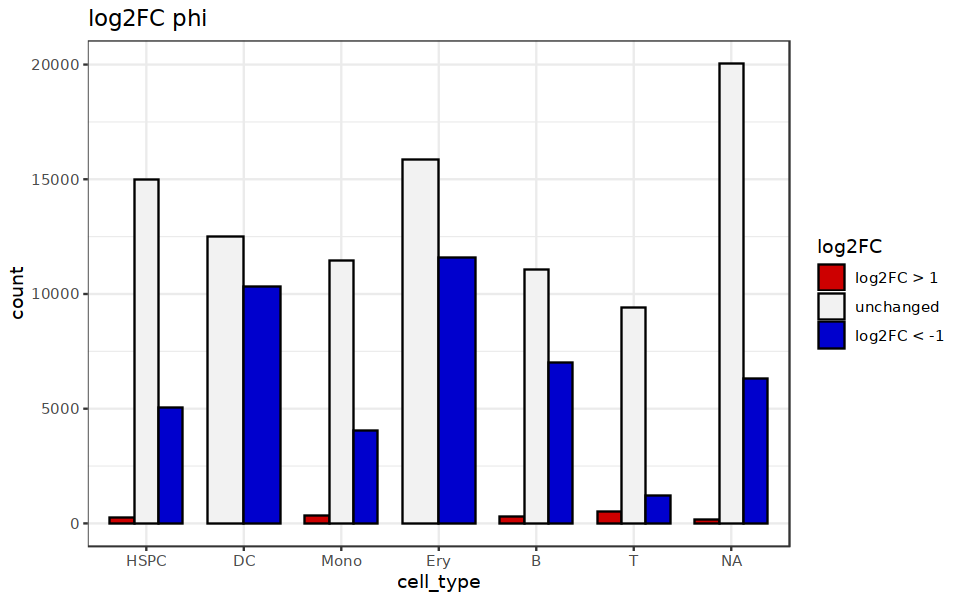

In [34]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_phi_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_phi_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c("HSPC"
                                     ,"DC"
                                    ,"Mono"
                                    ,"Ery"
                                    ,"B"
                                    ,"T")
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                       ,labels = c("log2FC > 1"
                                  ,"unchanged"
                                  ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC phi")+
    #ylim(c(0,3500))+
    theme_bw()

p

'data.frame':	120993 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 6 levels "HSPC"<"DC"<"Mono"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


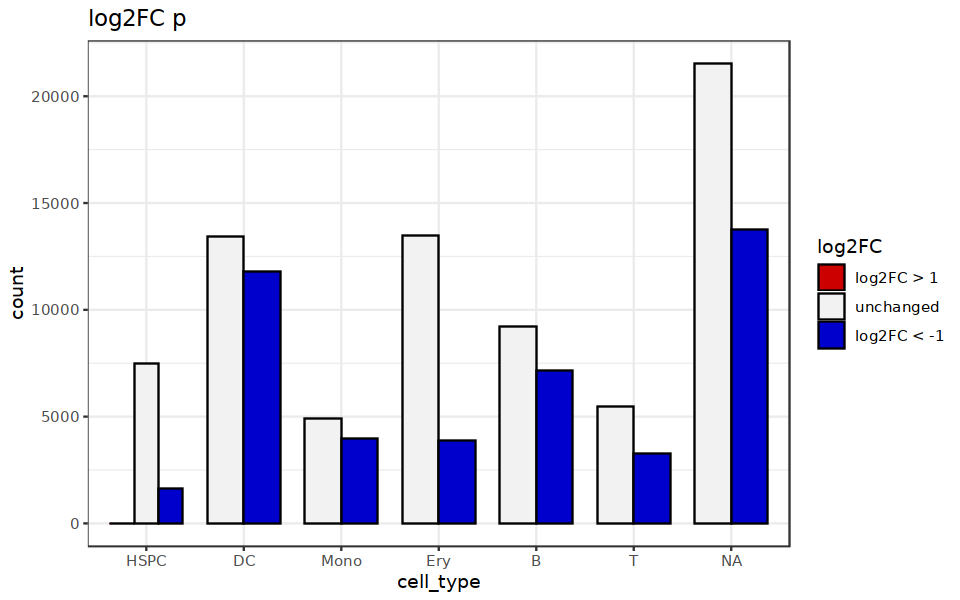

In [35]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_p_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_p_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c("HSPC"
                                     ,"DC"
                                    ,"Mono"
                                    ,"Ery"
                                    ,"B"
                                    ,"T")
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                    ,labels = c("log2FC > 1"
                               ,"unchanged"
                               ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC p")+
    #ylim(c(0,3500))+
    theme_bw()

p

### Classes of interactions

In this section, we will check which of the individual components (rho, phi, p) are driving the change of the interactions. For this, we will combine following forest plots: 
- log2 fold change of the interaction weight (`w`)
- log2 fold change of the cell type abundance of the sending cell type (`rho_s`)
- log2 fold change of the active fraction of the sending cell type expressing the ligand (`phi_s_l`)
- log2 fold change of the expression of the sending cell type expressing the ligand (`p_s_l`)
- log2 fold change of the cell type abundance of the receiving cell type (`rho_r`)
- log2 fold change of the active fraction of the receiving cell type expressing the receptor (`phi_r_r`)
- log2 fold change of the expression of the receiving cell type expressing the receptor (`p_r_r`)

We will first explore the interaction that were unchanged. We will start with the interactions that had a trully unchanged log2 fold change of the weight (i.e. -1 < `log2FC_weight` < 1), and then plot the interactions with eigther up- or down-regulated log2 fold change of the weight, which though didn't pass the adjusted p-value threshold.

#### Unchanged

In [36]:
idx_of_interest <- !idx_sign & idx_good
sum(idx_of_interest)

[1] 20088

 No log2FC of the w.

In [37]:
idx_w <- abs(interactions$anno_interactions$log2FC_weights) < 1
sum(idx_of_interest & idx_w)

[1] 8167

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "3453 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "1571 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "303 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "755 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "25 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "49 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "23 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "3 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "43 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "1496 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "

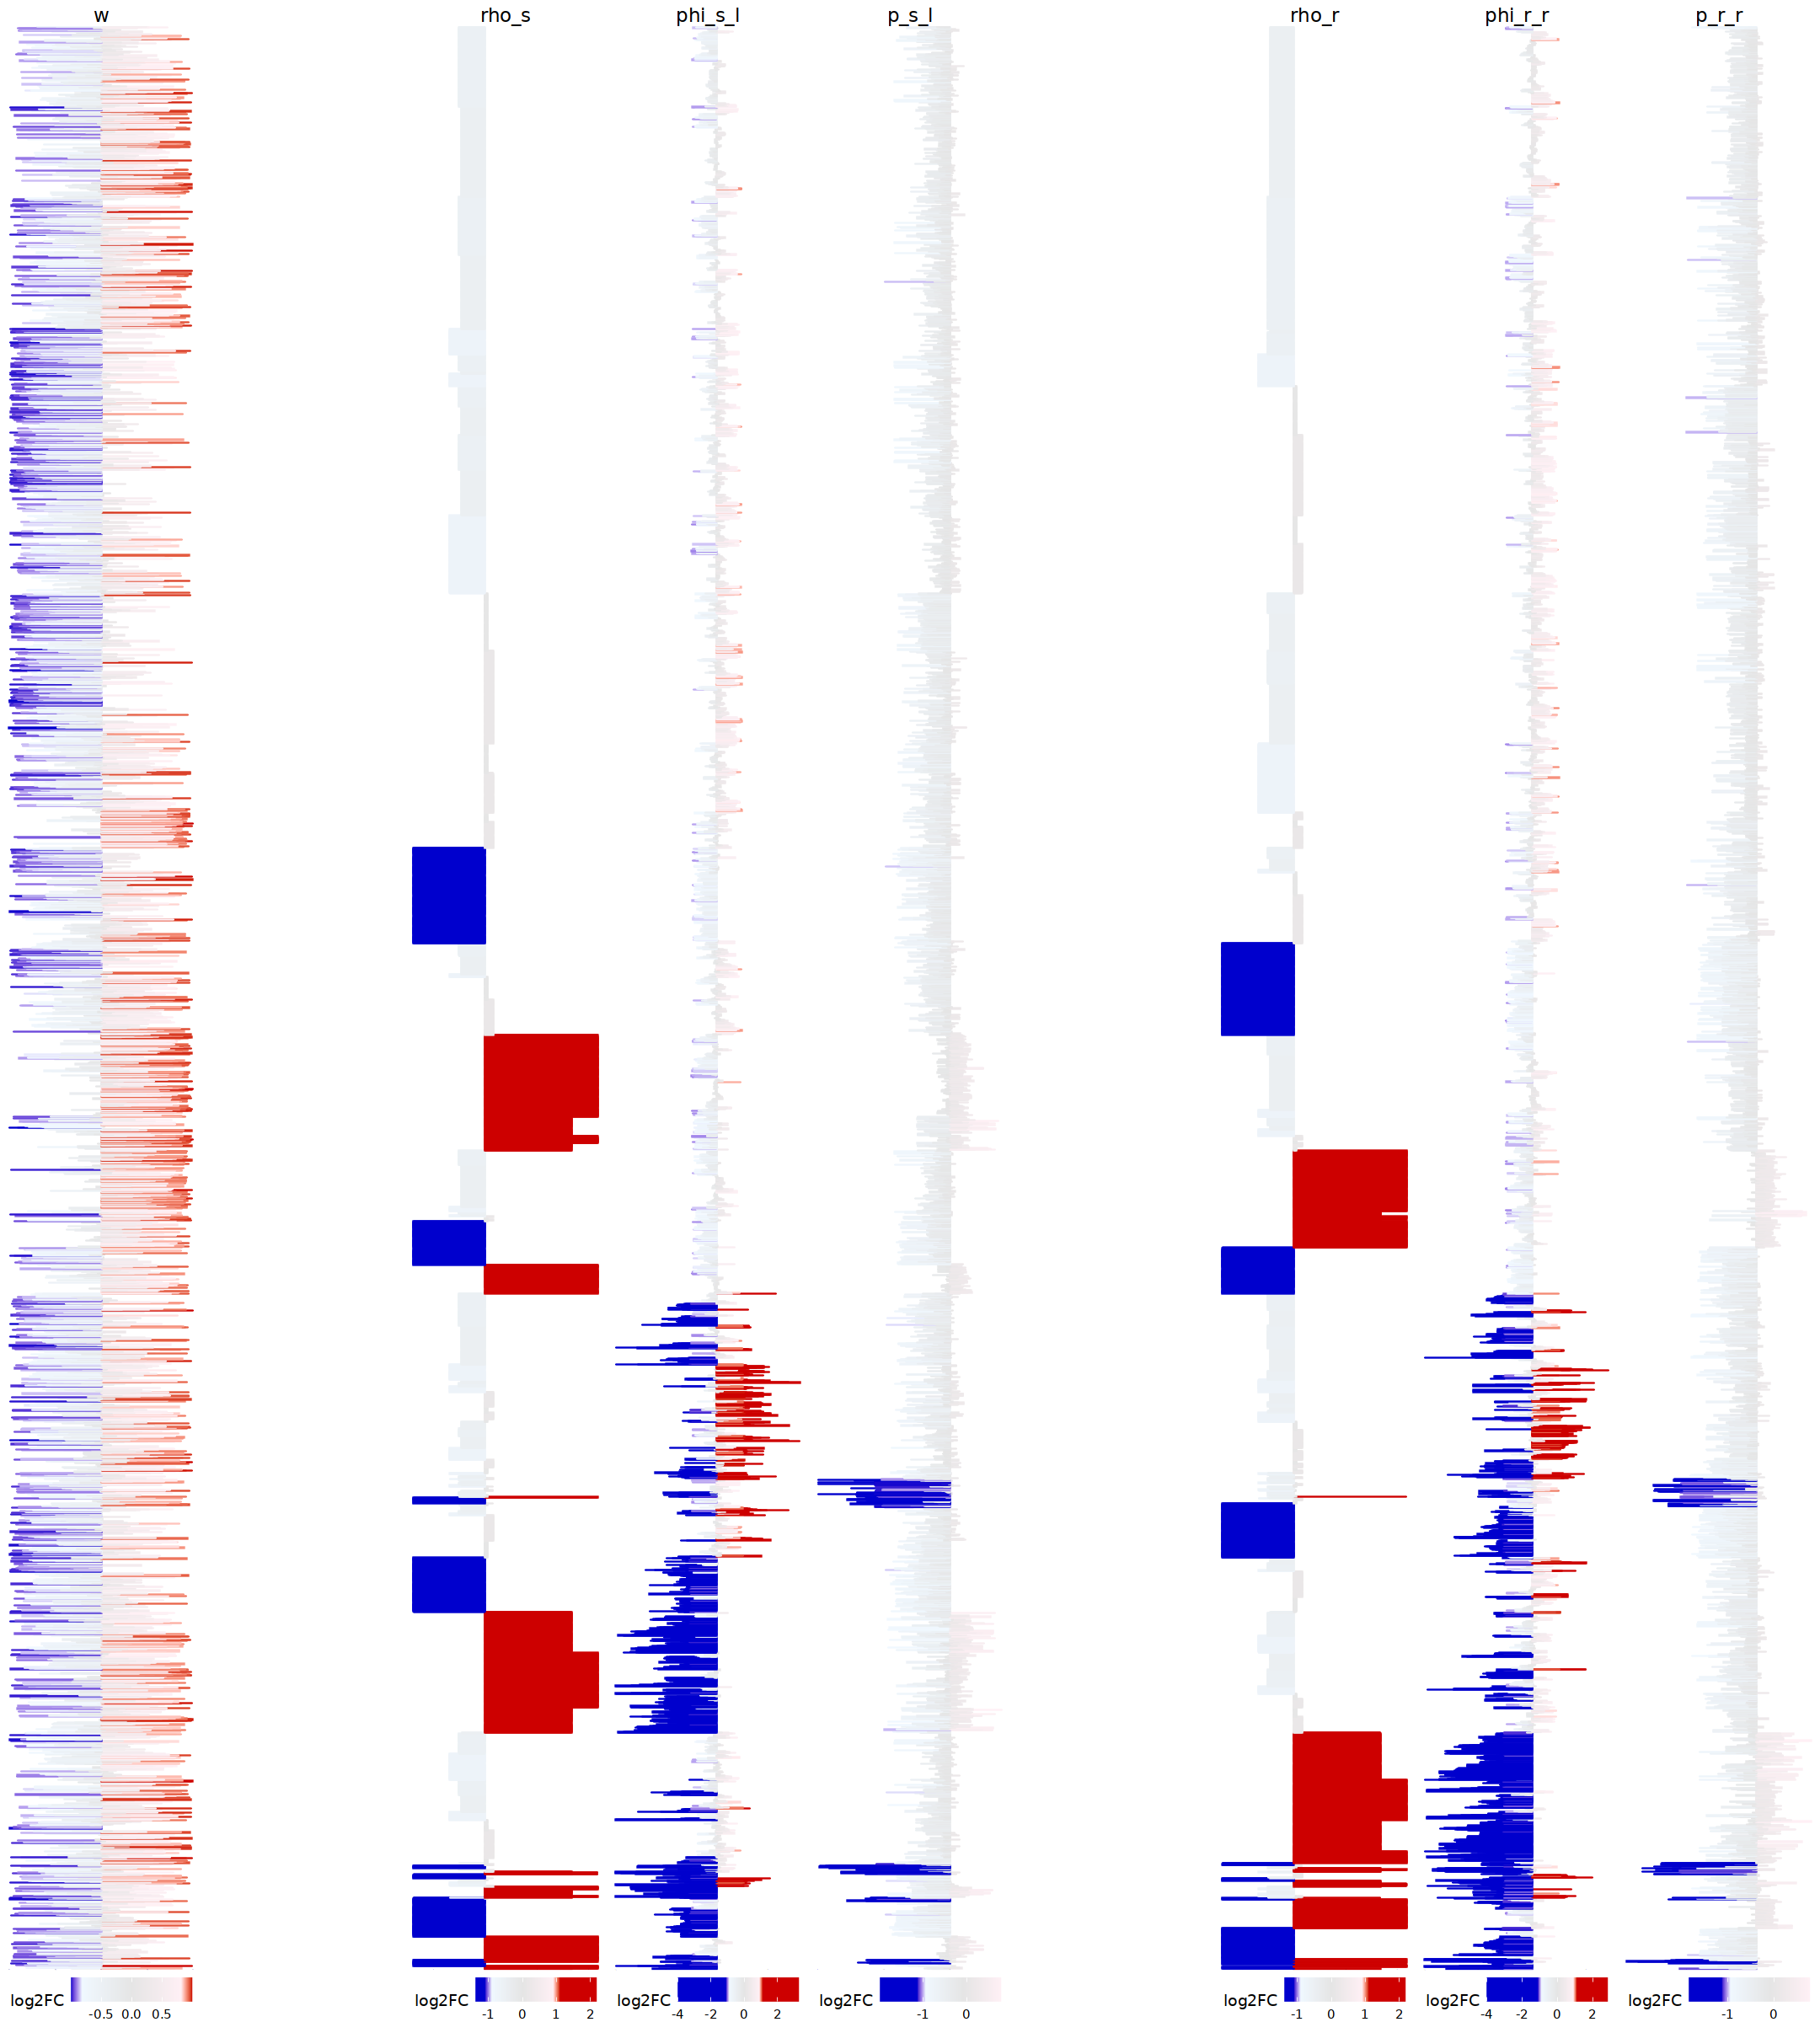

In [38]:
options(repr.plot.height = 20
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w > 1, but is not significant.

In [39]:
idx_w <- interactions$anno_interactions$log2FC_weights > 1
sum(idx_of_interest & idx_w)

[1] 5841

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "1278 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "2040 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "344 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "441 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "26 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "53 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "4 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "23 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "801 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "10

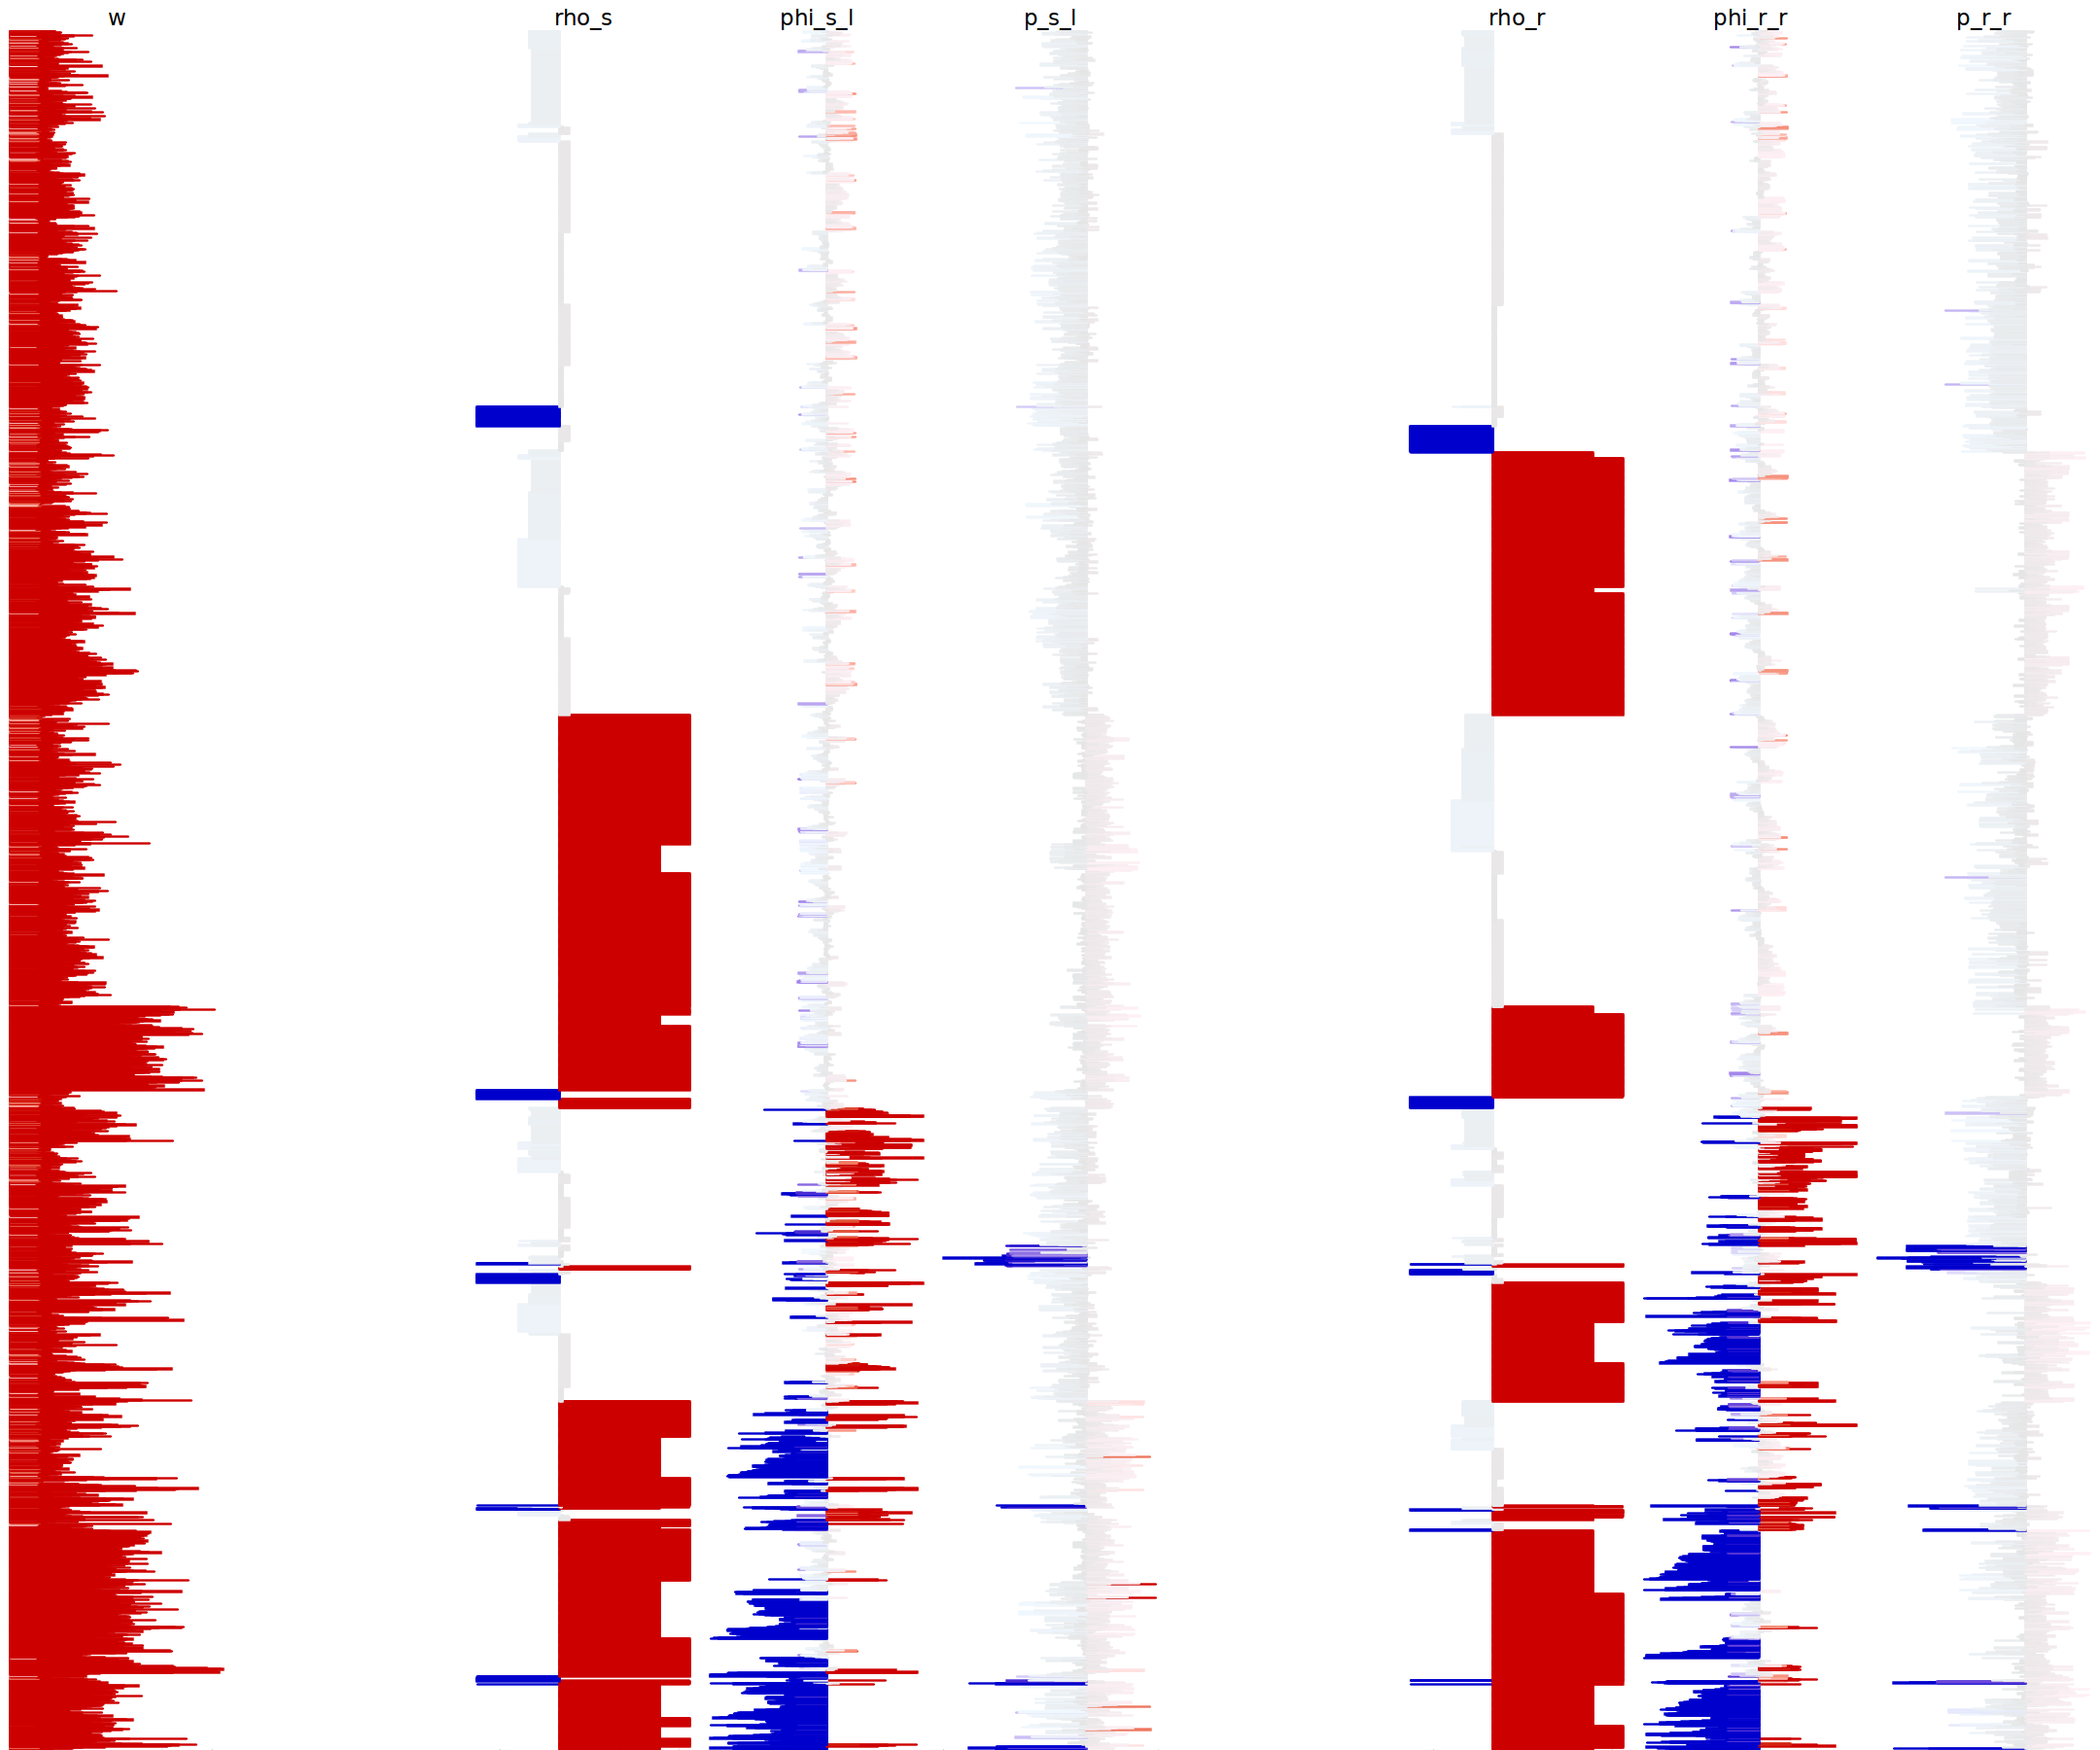

In [40]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions, plot_legend=FALSE)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w < -1, but is not significant.

In [41]:
idx_w <- interactions$anno_interactions$log2FC_weights < -1
sum(idx_of_interest & idx_w)

[1] 6080

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "2463 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "1035 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "81 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "757 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "38 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "43 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "1 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "31 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "6 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "11 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "1 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "989 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "17

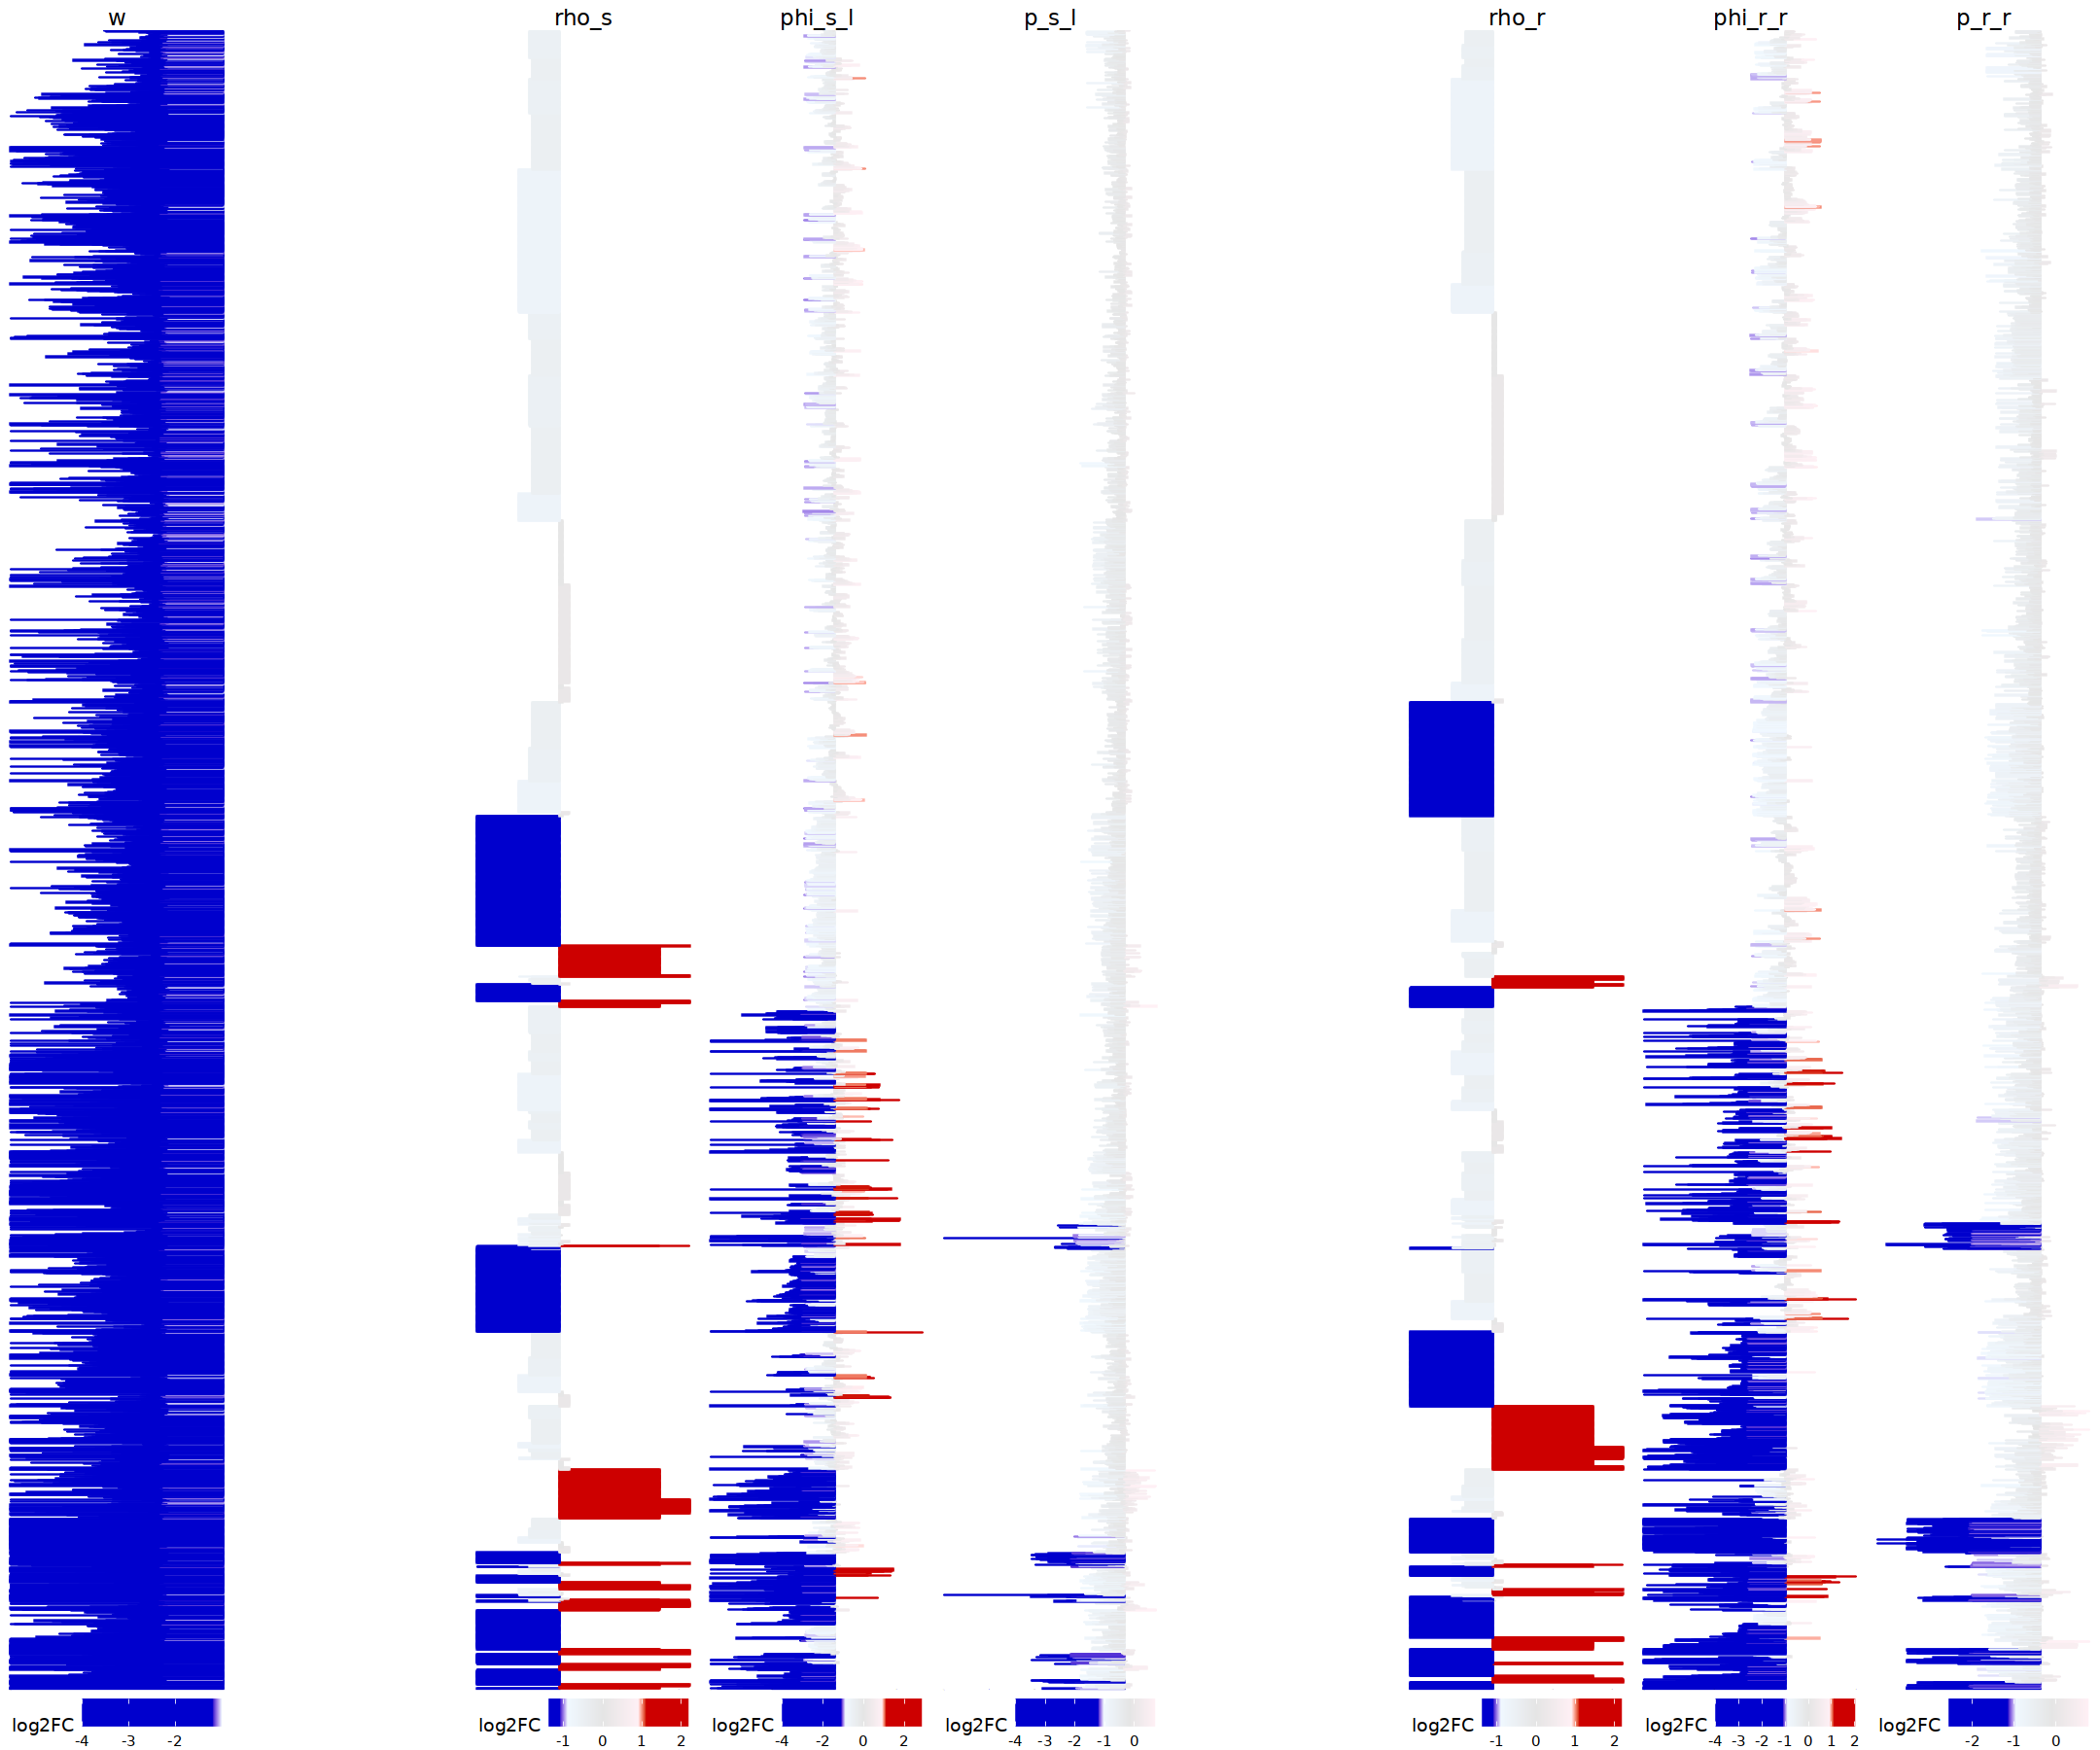

In [42]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Up-regulated

Now we will explore the interactions in which the `log2FC_weights` passed the upper log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [43]:
idx_of_interest <- idx_good & idx_sign & idx_up
sum(idx_of_interest)

[1] 109

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "1 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "6 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "1 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "47 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "13 interactions"

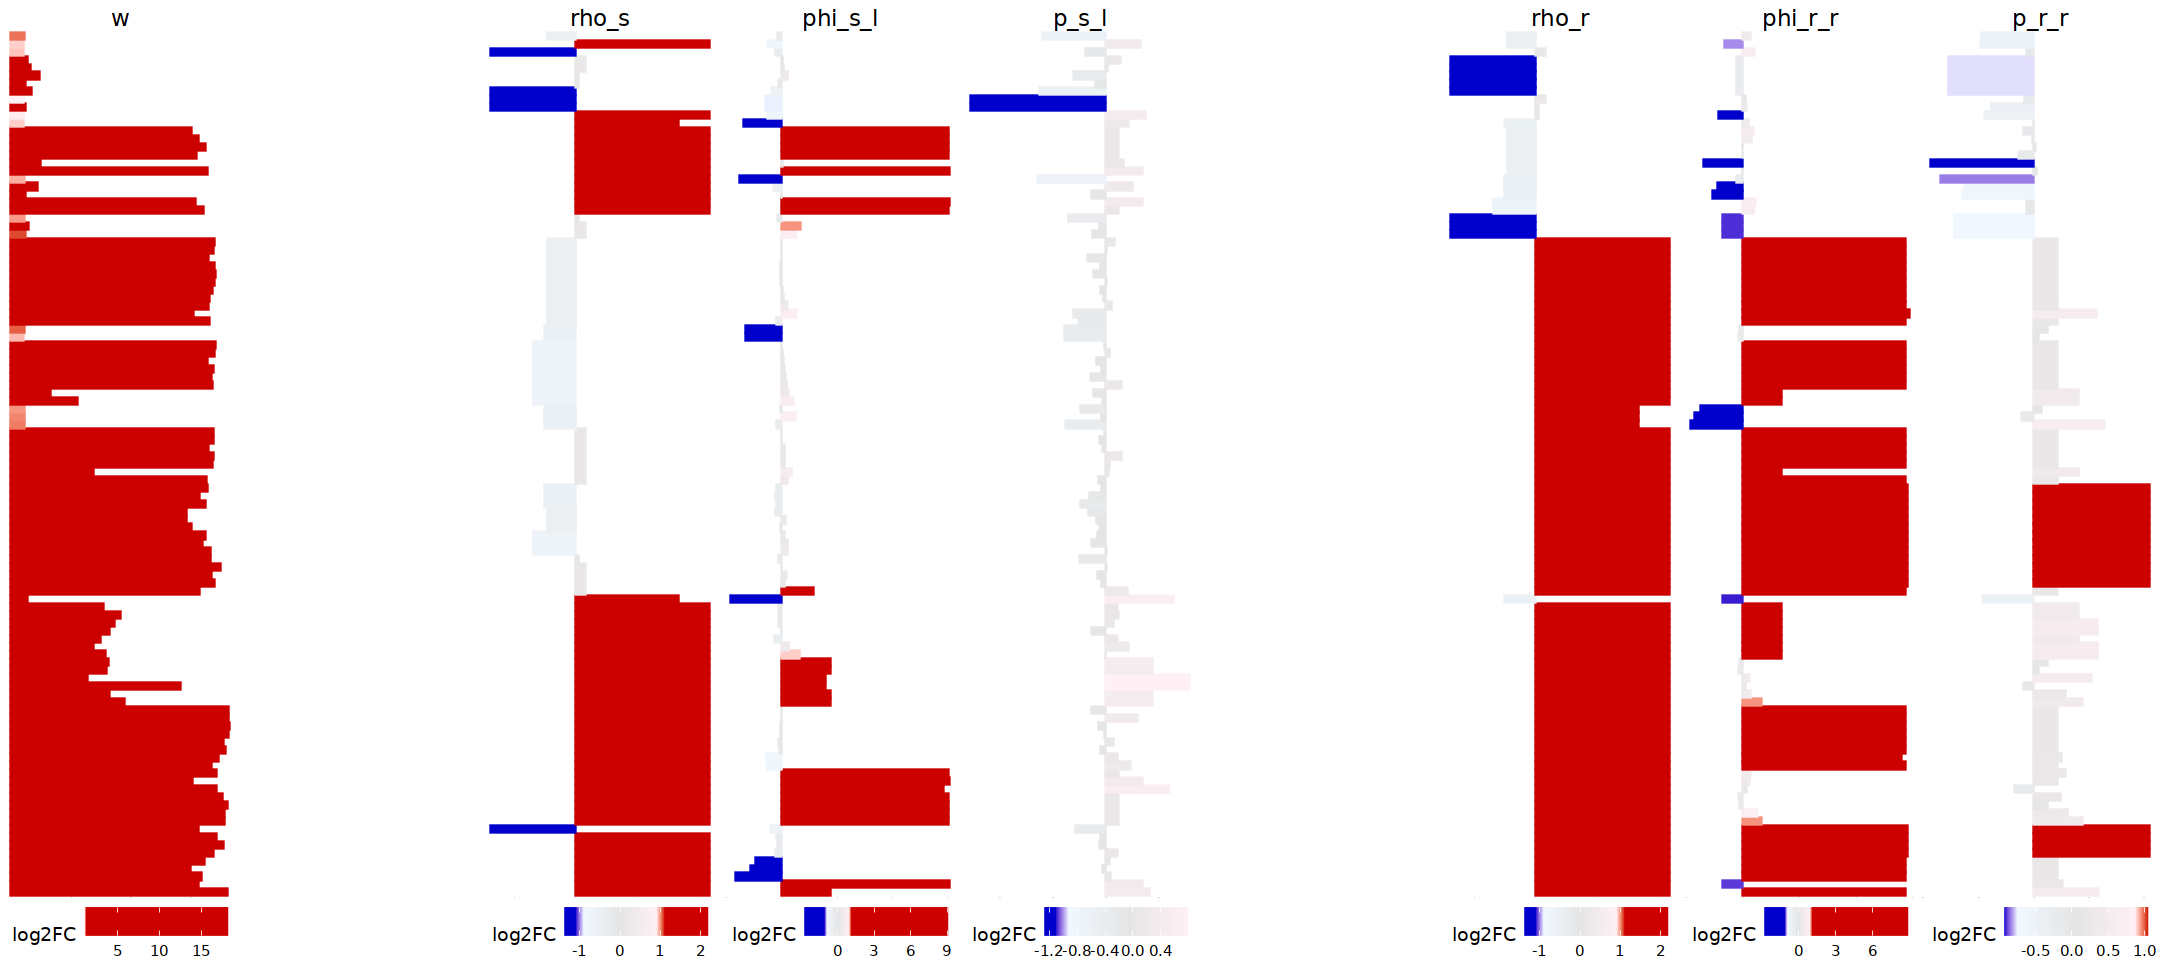

In [44]:
options(repr.plot.height = 8
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Down-regulated

Here we will explore the interactions in which the `log2FC_weights` passed the lower log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [45]:
idx_of_interest <- idx_good & idx_sign & idx_down
sum(idx_of_interest)

[1] 2635

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "270 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "144 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "24 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "367 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "25 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "4 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "41 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "6 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "16 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "920 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "165 i

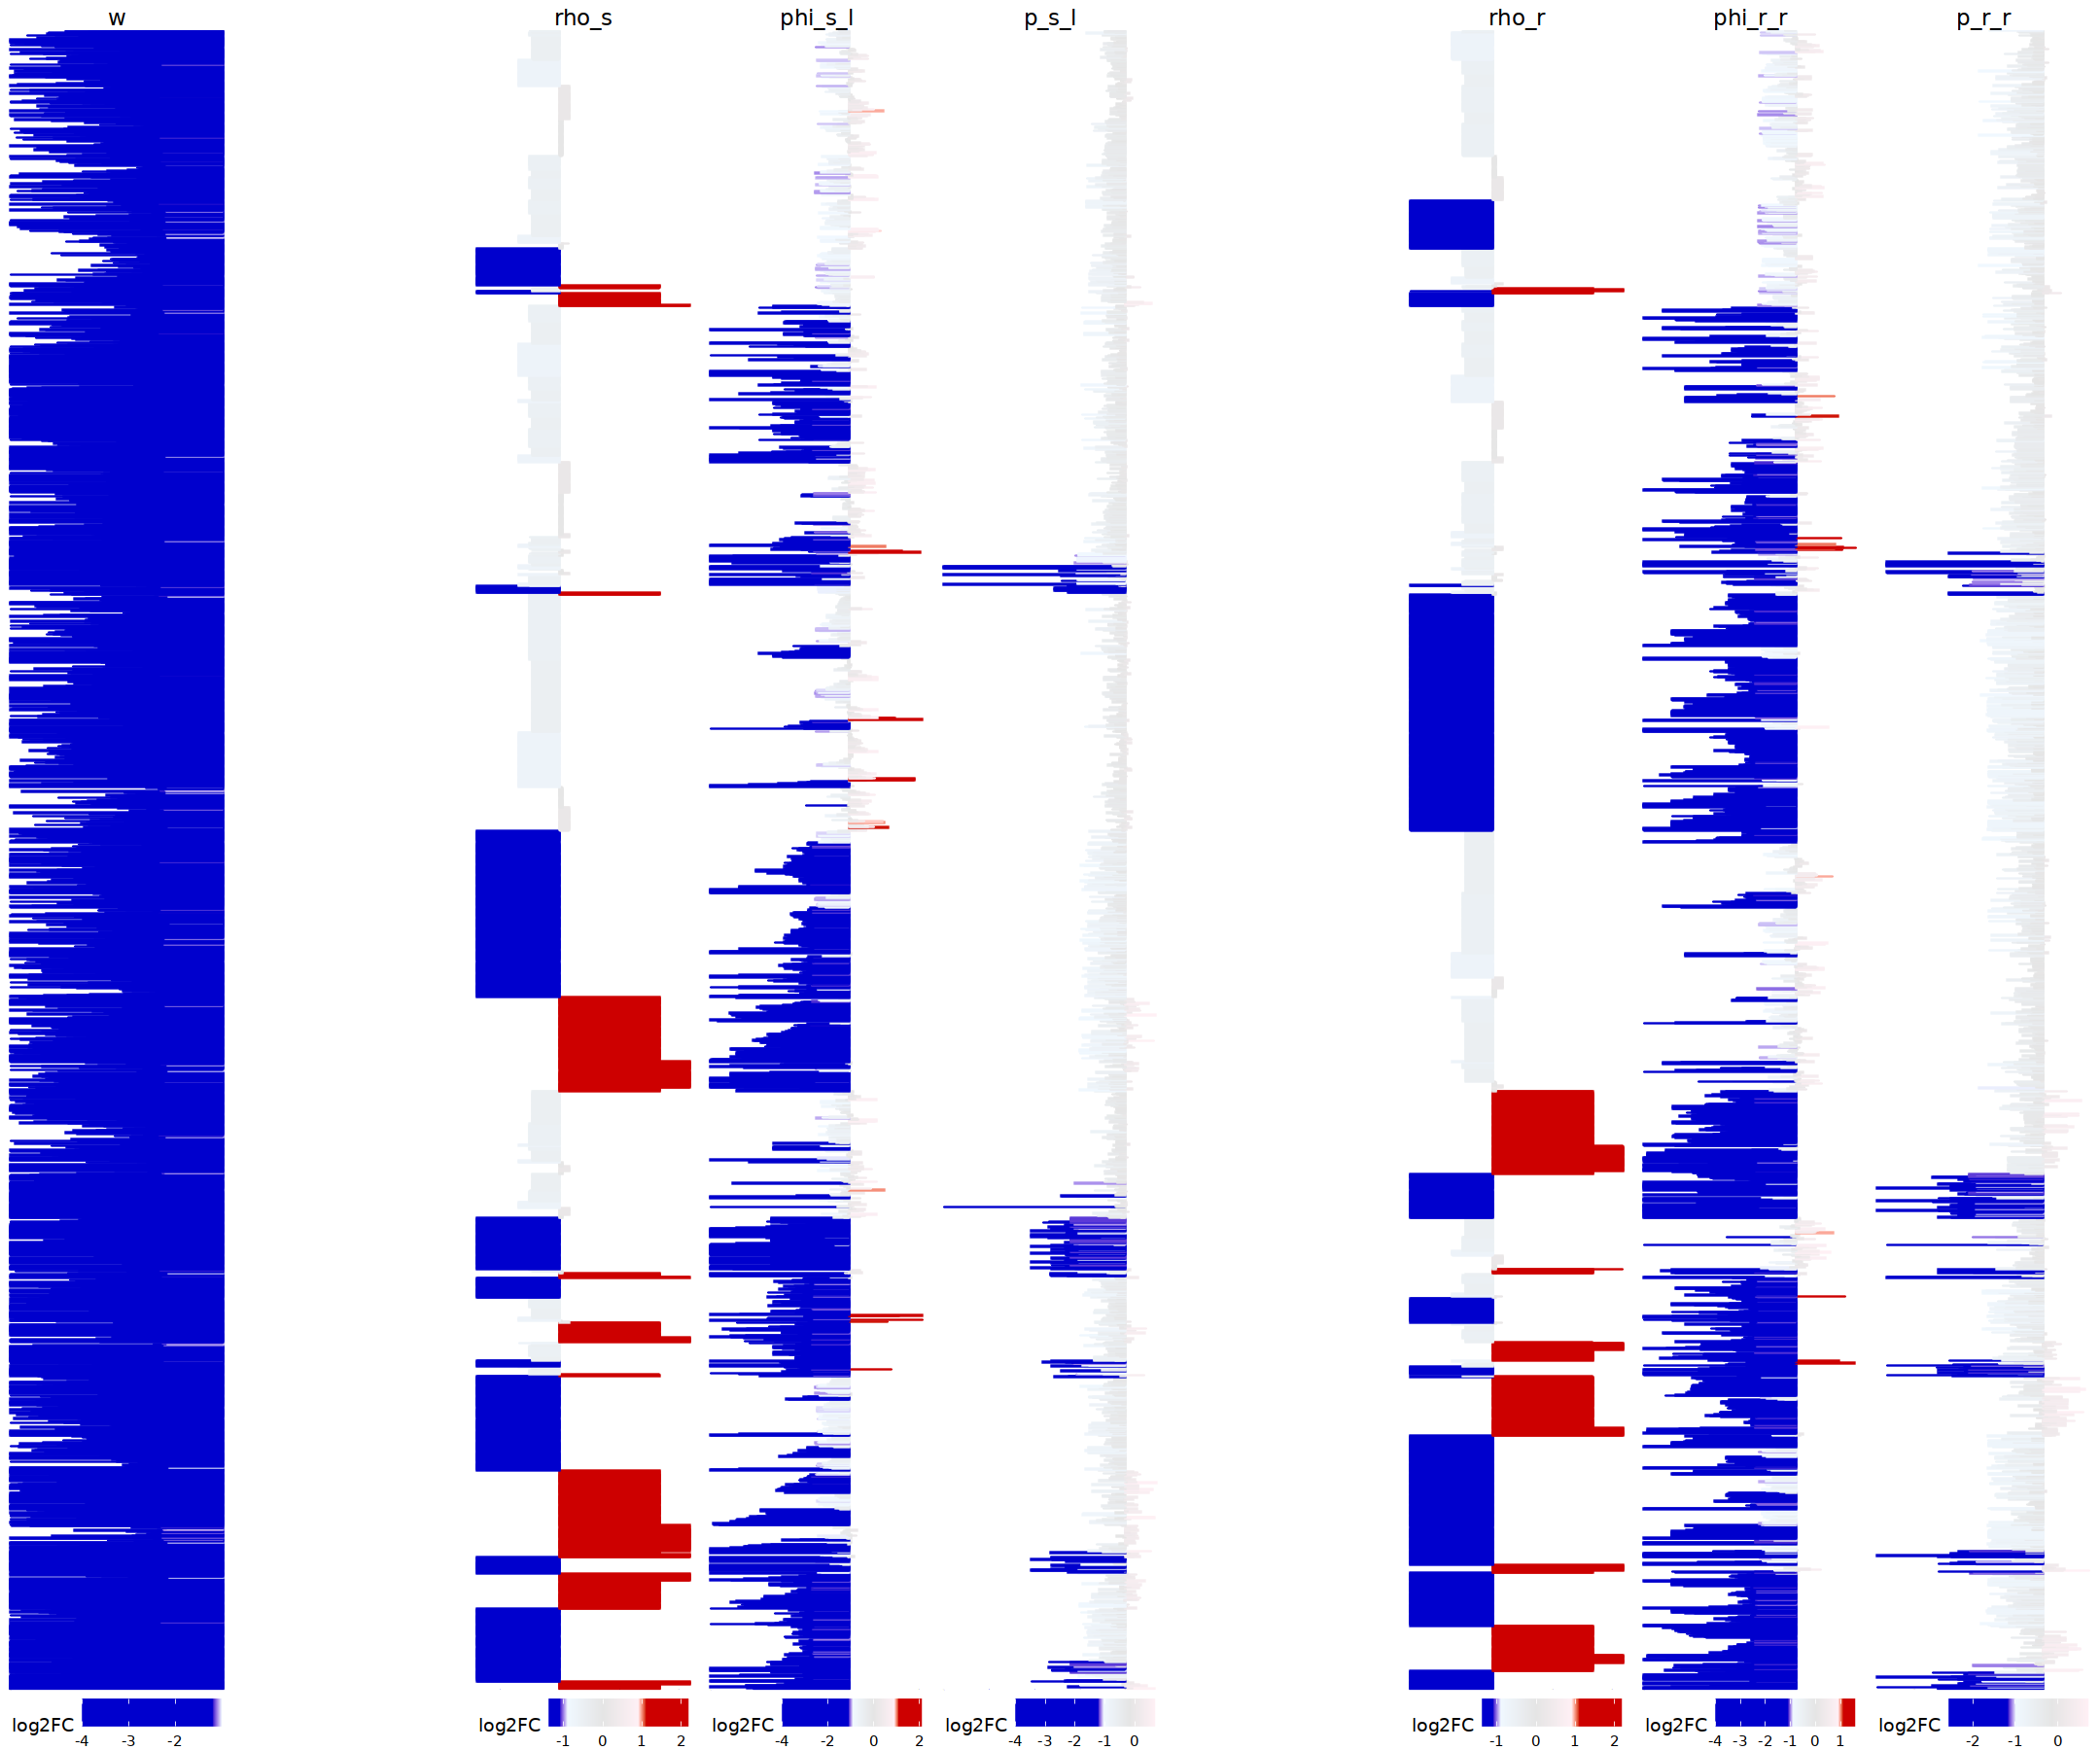

In [46]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

### Heatmap number of differential interactions

[1] "Mono"
[1] "Mono"
              interaction_ID log2FC_weights sign
17      Mono:ANXA1_Mono:FPR2      -1.353877 TRUE
35        Mono:CD48_Mono:CD2      -2.042923 TRUE
127 Mono:TNFSF8_Mono:TNFRSF8      -4.559338 TRUE
138      Mono:PVR_Mono:CD226      -2.272267 TRUE
280       Mono:APP_Mono:FPR2      -2.508518 TRUE
323       Mono:B2M_Mono:CD1C      -2.827132 TRUE
[1] 28
[1] "Mono"
[1] "Gran"
           interaction_ID log2FC_weights sign
2338 Mono:ANXA1_Gran:FPR1      -1.964107 TRUE
2339 Mono:ANXA1_Gran:FPR2     -18.047691 TRUE
2602   Mono:APP_Gran:FPR2     -17.126163 TRUE
2750 Mono:CALM1_Gran:HMMR      -3.253792 TRUE
2790  Mono:CAMP_Gran:FPR2     -16.912659 TRUE
3315 Mono:GNAI2_Gran:FPR1      -2.281556 TRUE
[1] 24
[1] "Mono"
[1] "T"
          interaction_ID log2FC_weights sign
4672   Mono:CD244_T:CD48      -2.244121 TRUE
4679     Mono:CD48_T:CD2      -2.330808 TRUE
4698  Mono:EFNA4_T:EPHA4     -14.891758 TRUE
4752    Mono:PVR_T:TIGIT      -5.098629 TRUE
4782    Mono:PVR_T:CD226     -17.

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[1] "Mono"
[1] "Mono"
           interaction_ID log2FC_weights sign
1772 Mono:POMC_Mono:GPR84       1.152092 TRUE
[1] 1
[1] "Mono"
[1] "Gran"
[1] interaction_ID log2FC_weights sign          
<0 rows> (or 0-length row.names)
[1] 0
[1] "Mono"
[1] "T"
[1] interaction_ID log2FC_weights sign          
<0 rows> (or 0-length row.names)
[1] 0
[1] "Mono"
[1] "NK"
[1] interaction_ID log2FC_weights sign          
<0 rows> (or 0-length row.names)
[1] 0
[1] "Mono"
[1] "B"
[1] interaction_ID log2FC_weights sign          
<0 rows> (or 0-length row.names)
[1] 0
[1] "Mono"
[1] "HSPC"
              interaction_ID log2FC_weights sign
12044  Mono:CALM1_HSPC:PDE1B       15.03711 TRUE
12057  Mono:CALM2_HSPC:PDE1B       14.64876 TRUE
12069  Mono:CALM3_HSPC:PDE1B       14.60462 TRUE
12166    Mono:CD36_HSPC:TLR4       16.46448 TRUE
12763   Mono:HMGB1_HSPC:TLR4       16.80705 TRUE
12786 Mono:HSP90B1_HSPC:TLR4       16.54663 TRUE
[1] 14
[1] "Mono"
[1] "Ery"
[1] interaction_ID log2FC_weights sign          
<0 row

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

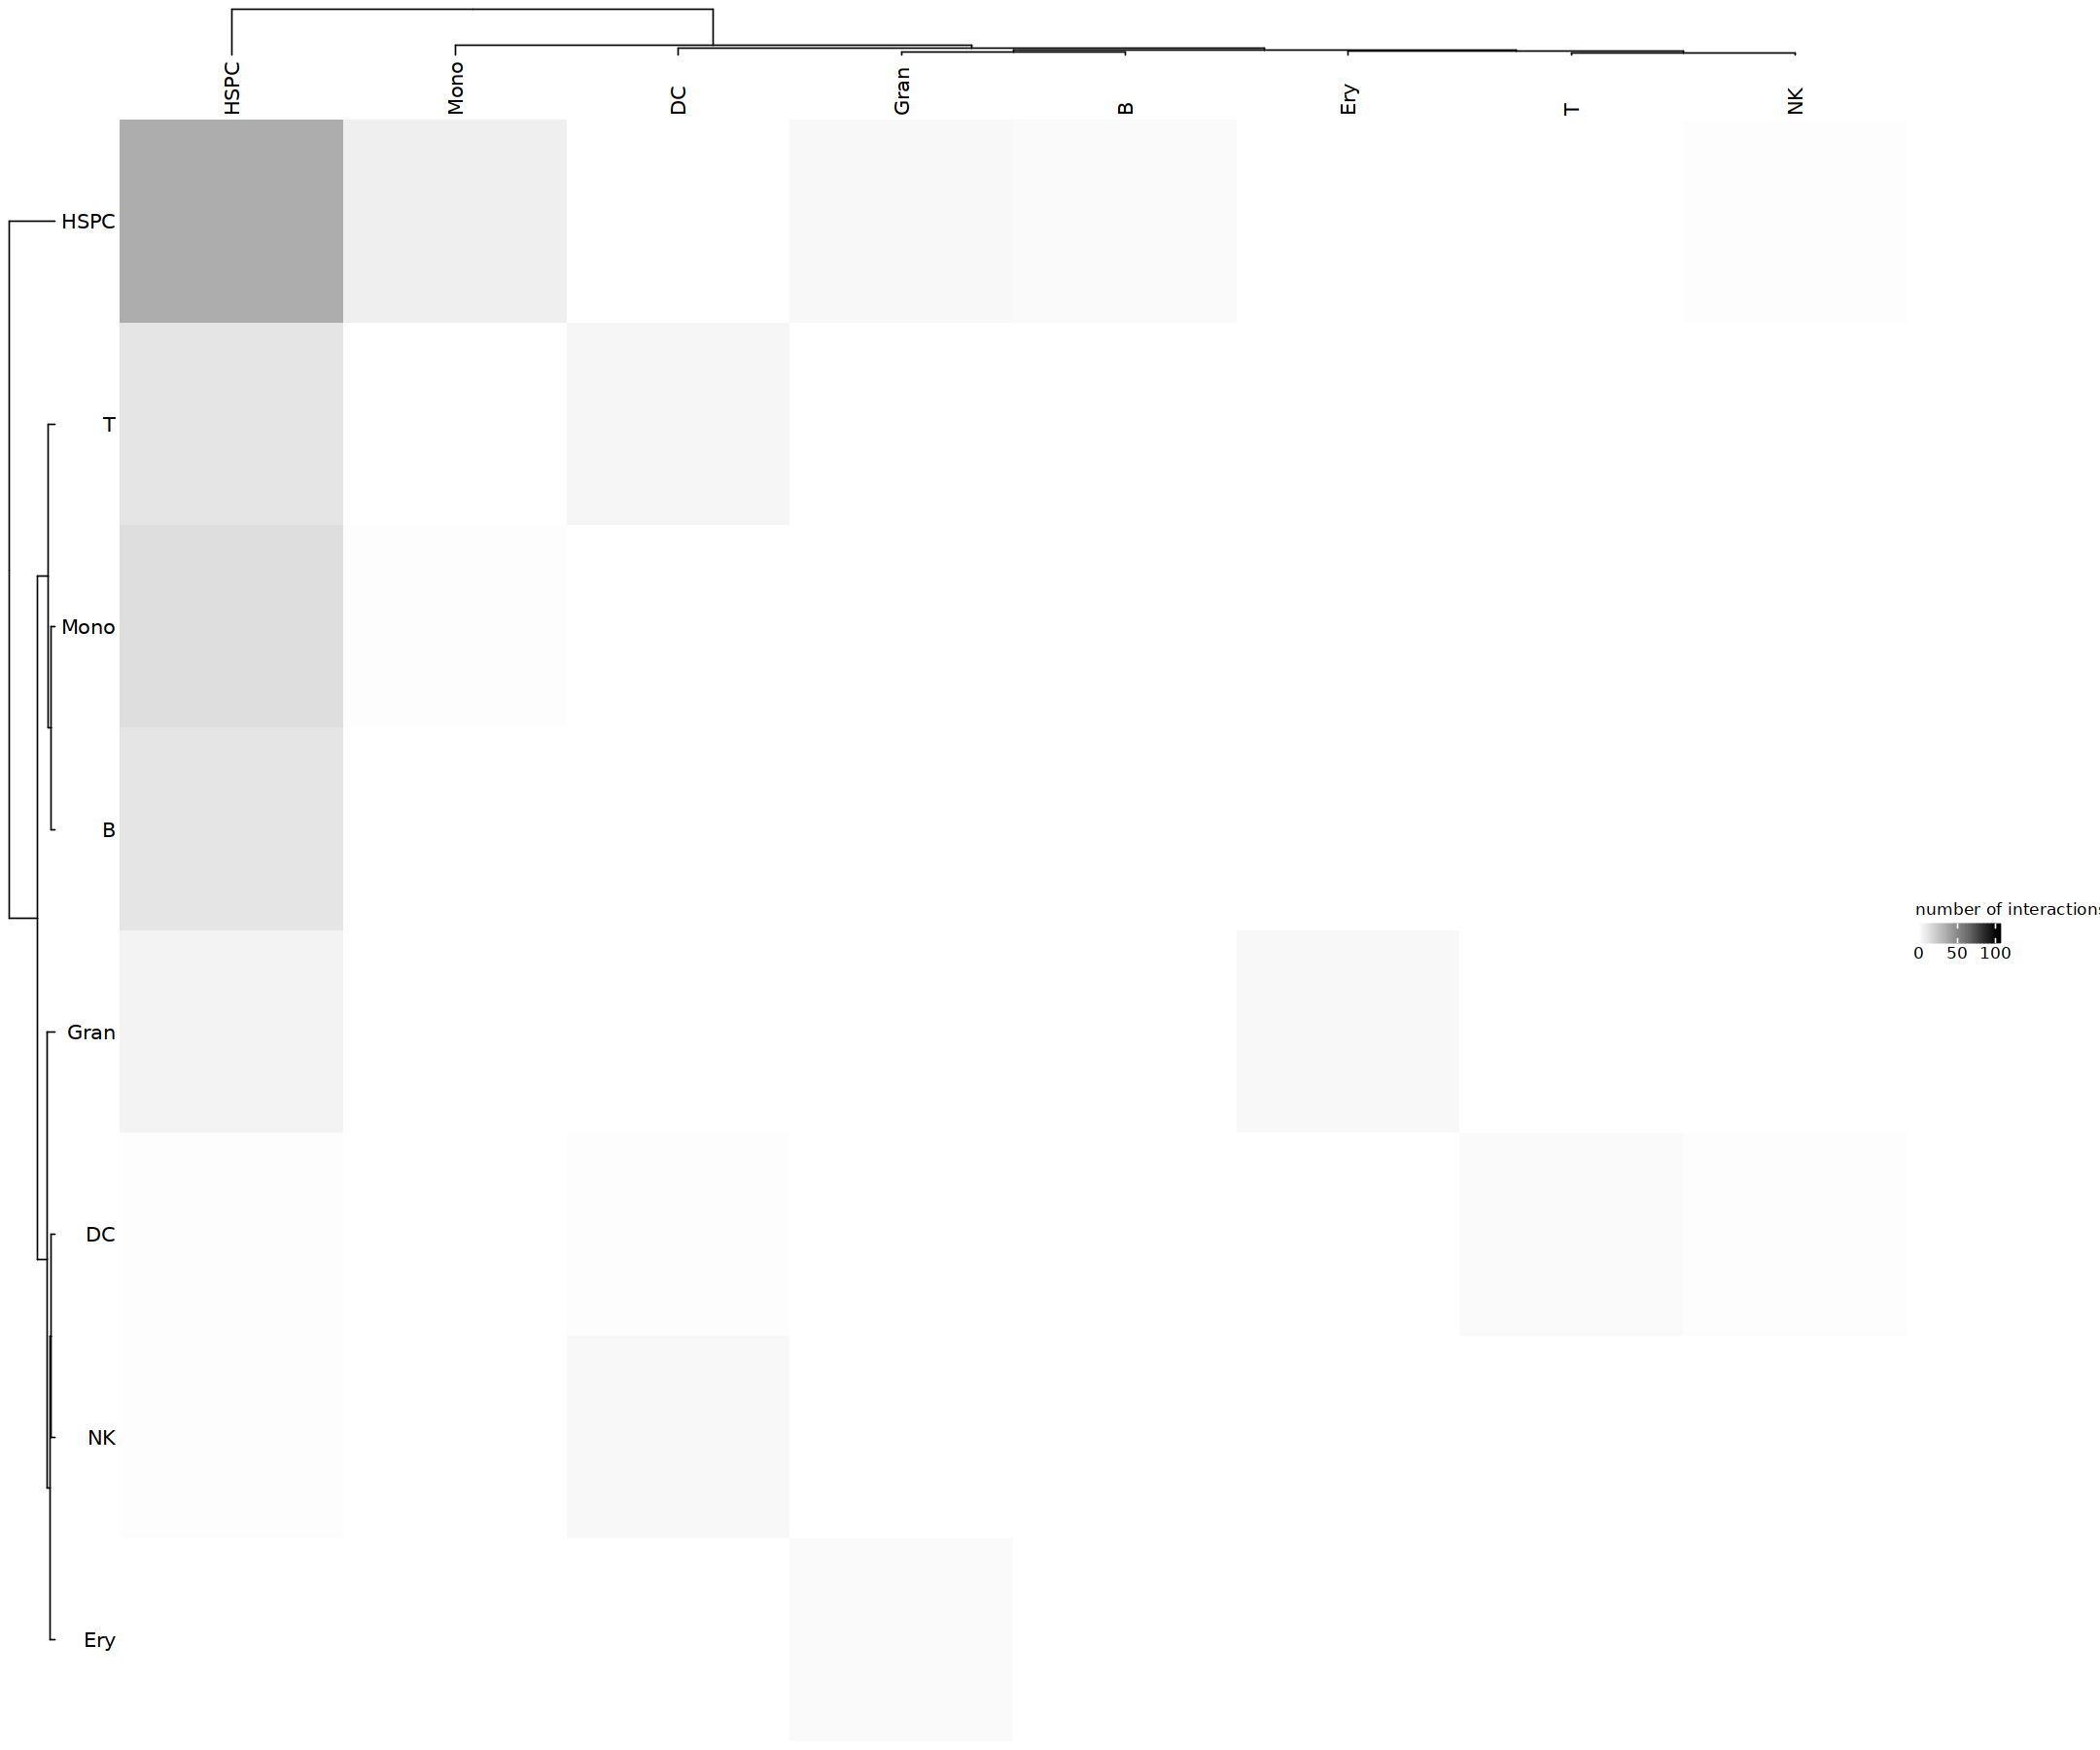

In [47]:
# mean number of interactions as heatmap
lapply(c("down"
         ,"up"
         #,"unchanged"
        )
       ,function(dir){
           # subset interactions
    ifelse(dir == "up"
              ,idx <- idx_good & idx_sign & idx_up
              ,ifelse(dir == "down"
                      ,idx <- idx_good & idx_sign & idx_down
                      ,idx <- !idx_sign & idx_good
                     )
              )
    
    # create a dummy data frame
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types
    
    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send
        
        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec
            
            print(send)
            print(rec)
            print(head(interactions$anno_interactions[idx & idx_send & idx_rec,c("interaction_ID","log2FC_weights", "sign")]))
            print(sum(idx & idx_send & idx_rec))
            
            df[send,rec] <- sum(idx & idx_send & idx_rec)
            
        }
    }
    
    print(df)
           
    my_color <-  colorRamp2(seq(0
                                ,100 #300
                                , length = 4)
                            , c("white","gray70","gray40","black"))
    
    h <- Heatmap(df
                 ,name = "number of interactions"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                )
           print(h
             #,heatmap_legend_side = "bottom"
                )
           
    pdf(file=paste0("figures/heatmap_cellTypes_number_"
                   ,dir
                   ,".pdf"))
          print(h
             #,heatmap_legend_side = "bottom"
               )
           dev.off()
    
       }
       )

### GO

[1] "Mono"
[1] "up"
 'table' int [1:23(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:23] "ANXA2" "CALM1" "CALM2" "CALM3" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:23(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:23] "ANXA2" "CALM1" "CALM2" "CALM3" ...
NULL
'data.frame':	23 obs. of  2 variables:
 $ SYMBOL  : chr  "ANXA2" "CALM1" "CALM2" "CALM3" ...
 $ ENTREZID: chr  "302" "801" "805" "808" ...
NULL
[1] "Mono"
[1] "down"
 'table' int [1:319(1d)] 31 22 22 17 14 14 14 13 13 12 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:319] "EPOR" "CD2" "HP" "THBS1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:319(1d)] 31 22 22 17 14 14 14 13 13 12 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:319] "EPOR" "CD2" "HP" "THBS1" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "EPOR" "CD2" "HP" "THBS1" ...
 $ ENTREZID: chr  "2057" "914" "3240" "7057" ...
NULL
[1] "Gran"
[1] "up"
 'table' int [1:12(1d)] 2 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:12] "F13A1" "ADAM17" "ADRB2" "CALM1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



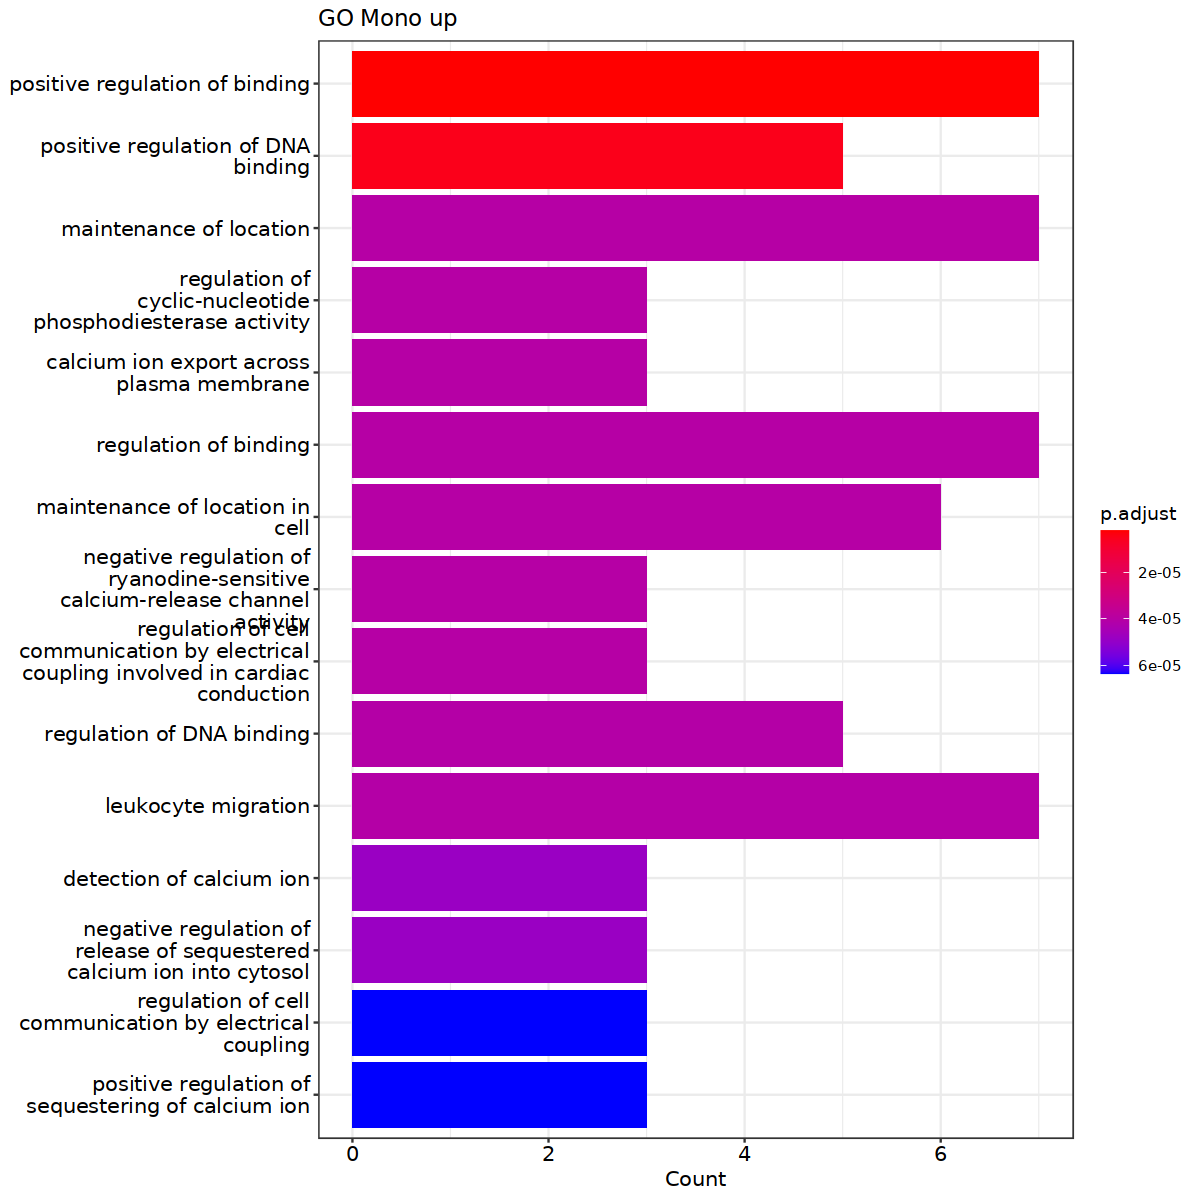

 'table' int [1:12(1d)] 2 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:12] "F13A1" "ADAM17" "ADRB2" "CALM1" ...
NULL
'data.frame':	12 obs. of  2 variables:
 $ SYMBOL  : chr  "F13A1" "ADAM17" "ADRB2" "CALM1" ...
 $ ENTREZID: chr  "2162" "6868" "154" "801" ...
NULL
[1] "Gran"
[1] "down"
 'table' int [1:236(1d)] 43 30 25 25 22 21 20 19 17 17 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:236] "THBS1" "LRP1" "ADRB2" "CD14" ...
NULL


'select()' returned 1:1 mapping between keys and columns



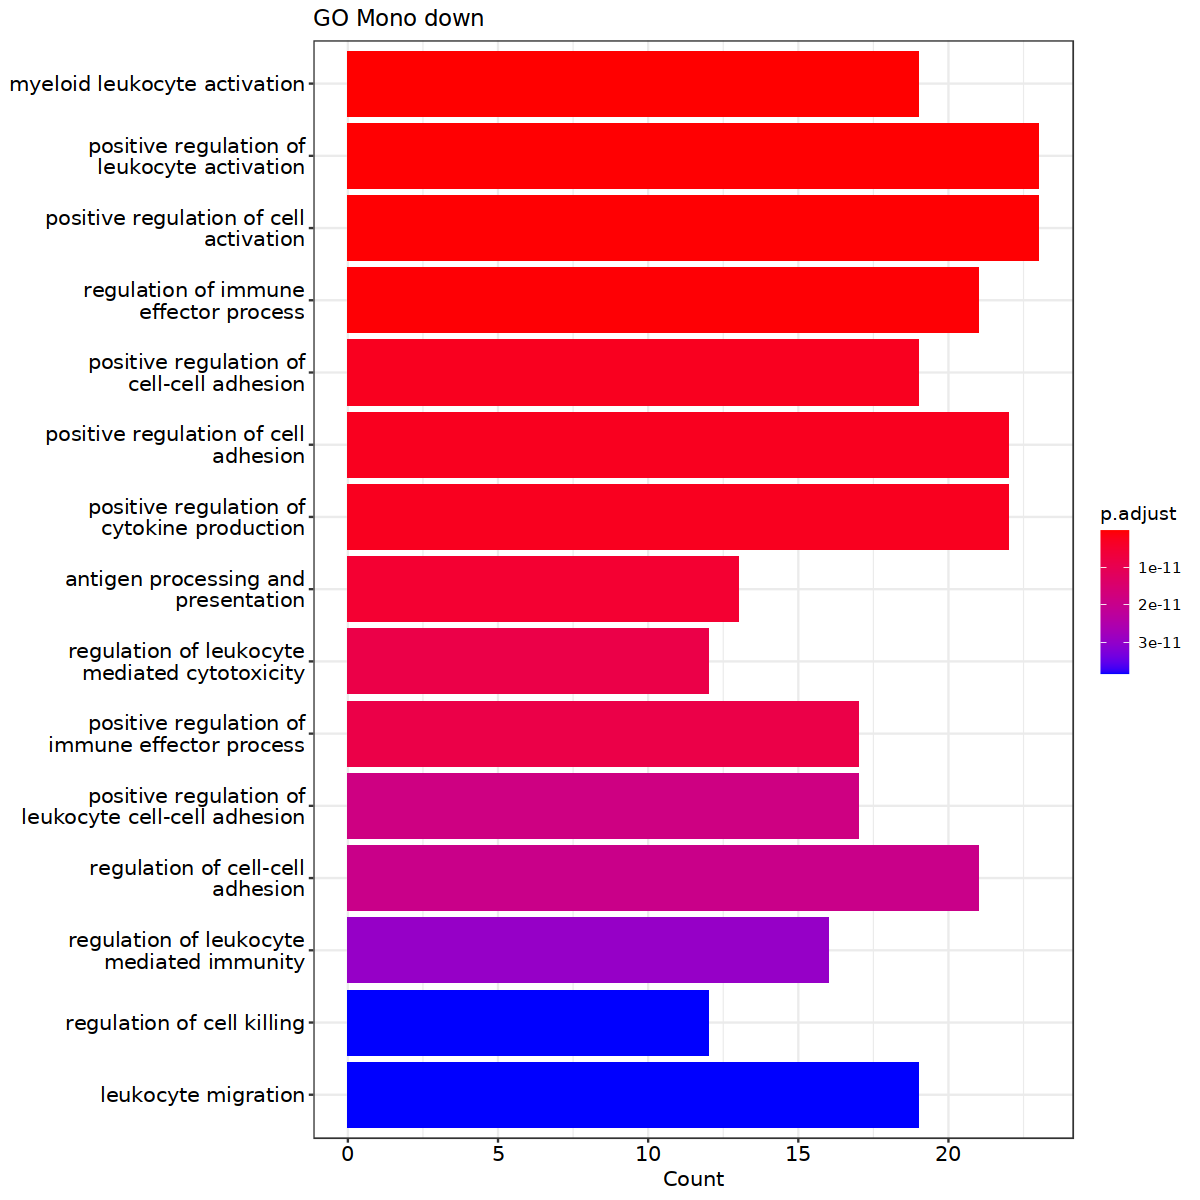

 'table' int [1:236(1d)] 43 30 25 25 22 21 20 19 17 17 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:236] "THBS1" "LRP1" "ADRB2" "CD14" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "THBS1" "LRP1" "ADRB2" "CD14" ...
 $ ENTREZID: chr  "7057" "4035" "154" "929" ...
NULL
[1] "T"
[1] "up"
 'table' int [1:17(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:17] "CALM1" "CALM2" "CALM3" "CD52" ...
NULL


'select()' returned 1:1 mapping between keys and columns



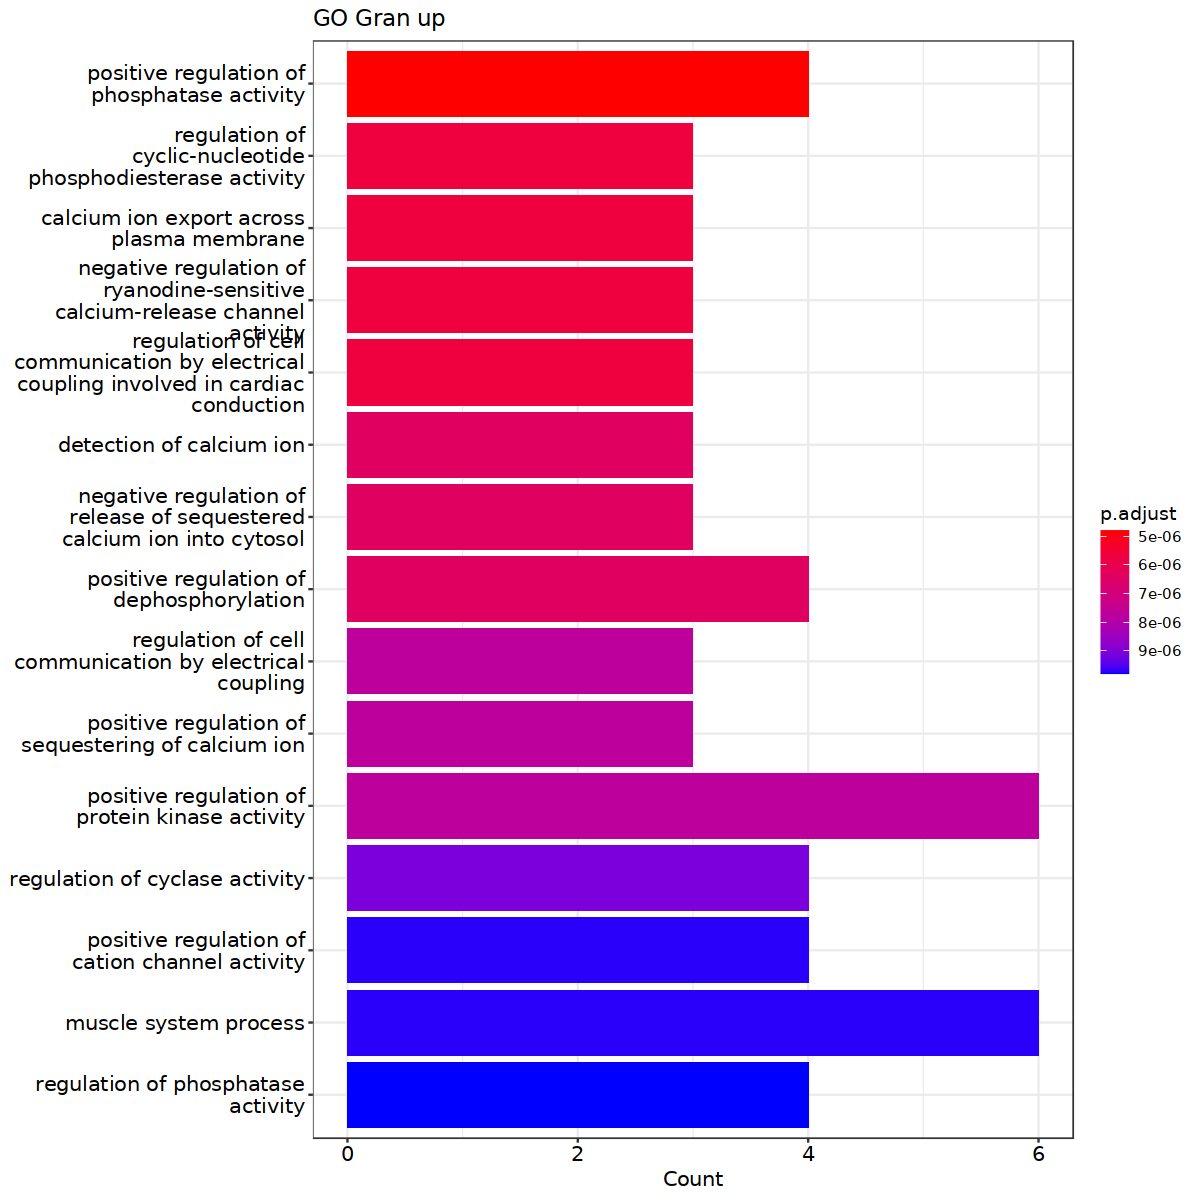

 'table' int [1:17(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:17] "CALM1" "CALM2" "CALM3" "CD52" ...
NULL
'data.frame':	17 obs. of  2 variables:
 $ SYMBOL  : chr  "CALM1" "CALM2" "CALM3" "CD52" ...
 $ ENTREZID: chr  "801" "805" "808" "1043" ...
NULL
[1] "T"
[1] "down"
 'table' int [1:161(1d)] 9 8 8 7 6 6 5 5 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:161] "ITGB1" "CD36" "ITGA4" "GNAI2" ...
NULL


'select()' returned 1:1 mapping between keys and columns



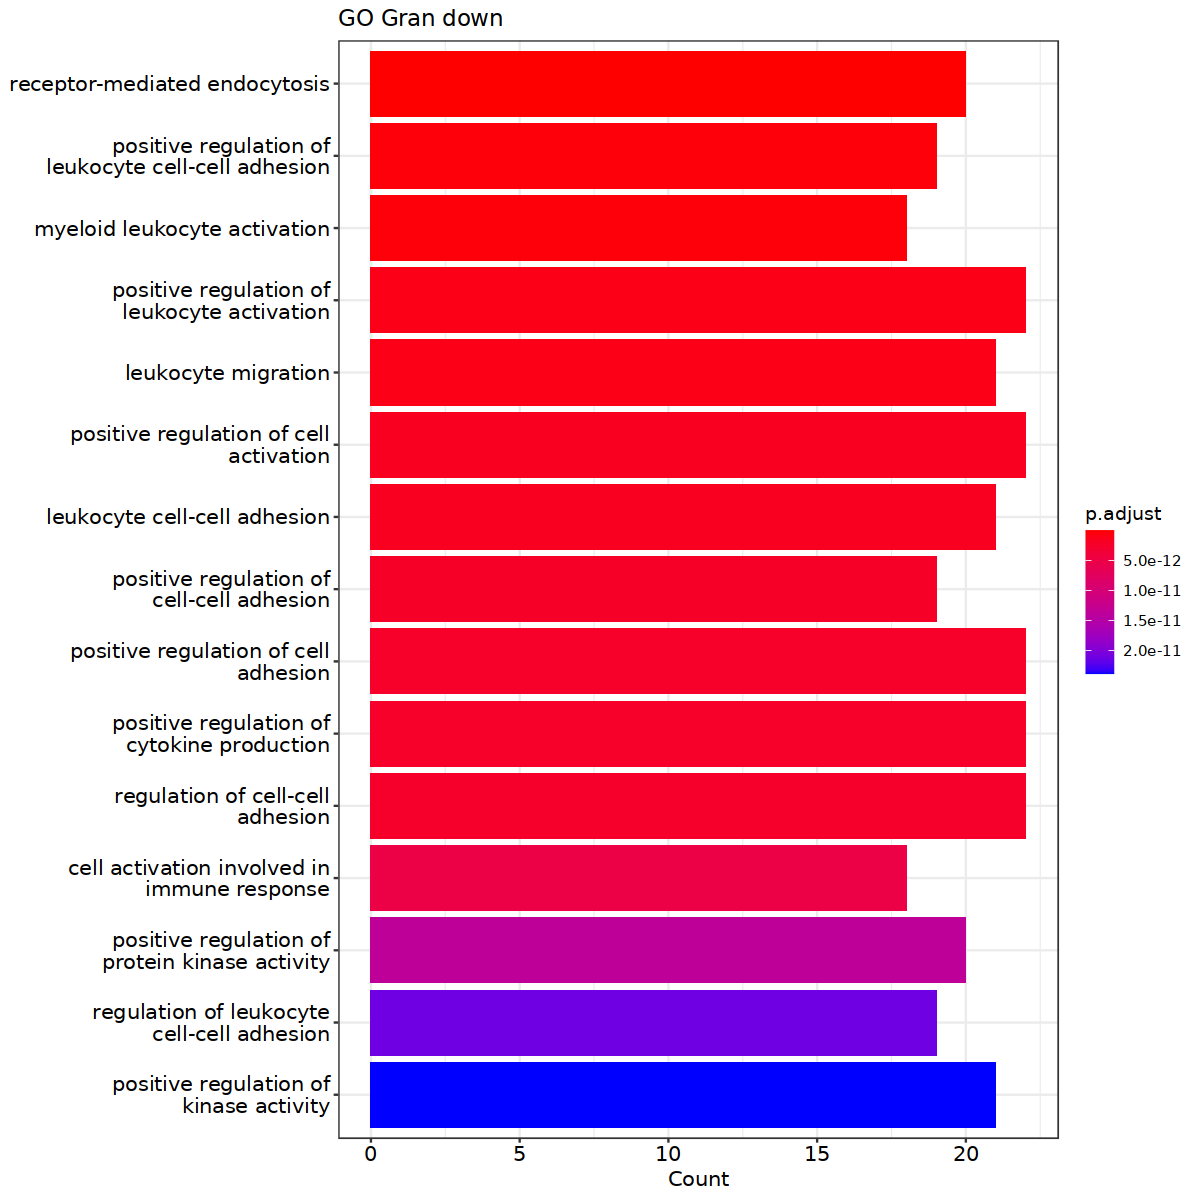

 'table' int [1:161(1d)] 9 8 8 7 6 6 5 5 5 5 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:161] "ITGB1" "CD36" "ITGA4" "GNAI2" ...
NULL
'data.frame':	99 obs. of  2 variables:
 $ SYMBOL  : chr  "ITGB1" "CD36" "ITGA4" "GNAI2" ...
 $ ENTREZID: chr  "3688" "948" "3676" "2771" ...
NULL
[1] "NK"
[1] "up"
 'table' int [1:6(1d)] 1 1 1 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:6] "CALM1" "CD52" "COPA" "HLA-B" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:6(1d)] 1 1 1 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:6] "CALM1" "CD52" "COPA" "HLA-B" ...
NULL
'data.frame':	6 obs. of  2 variables:
 $ SYMBOL  : chr  "CALM1" "CD52" "COPA" "HLA-B" ...
 $ ENTREZID: chr  "801" "1043" "1314" "3106" ...
NULL
[1] "NK"
[1] "down"
 'table' int [1:134(1d)] 17 9 8 7 7 7 7 6 6 6 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:134] "ITGB1" "SELL" "B2M" "GNAI2" ...
NULL


'select()' returned 1:1 mapping between keys and columns



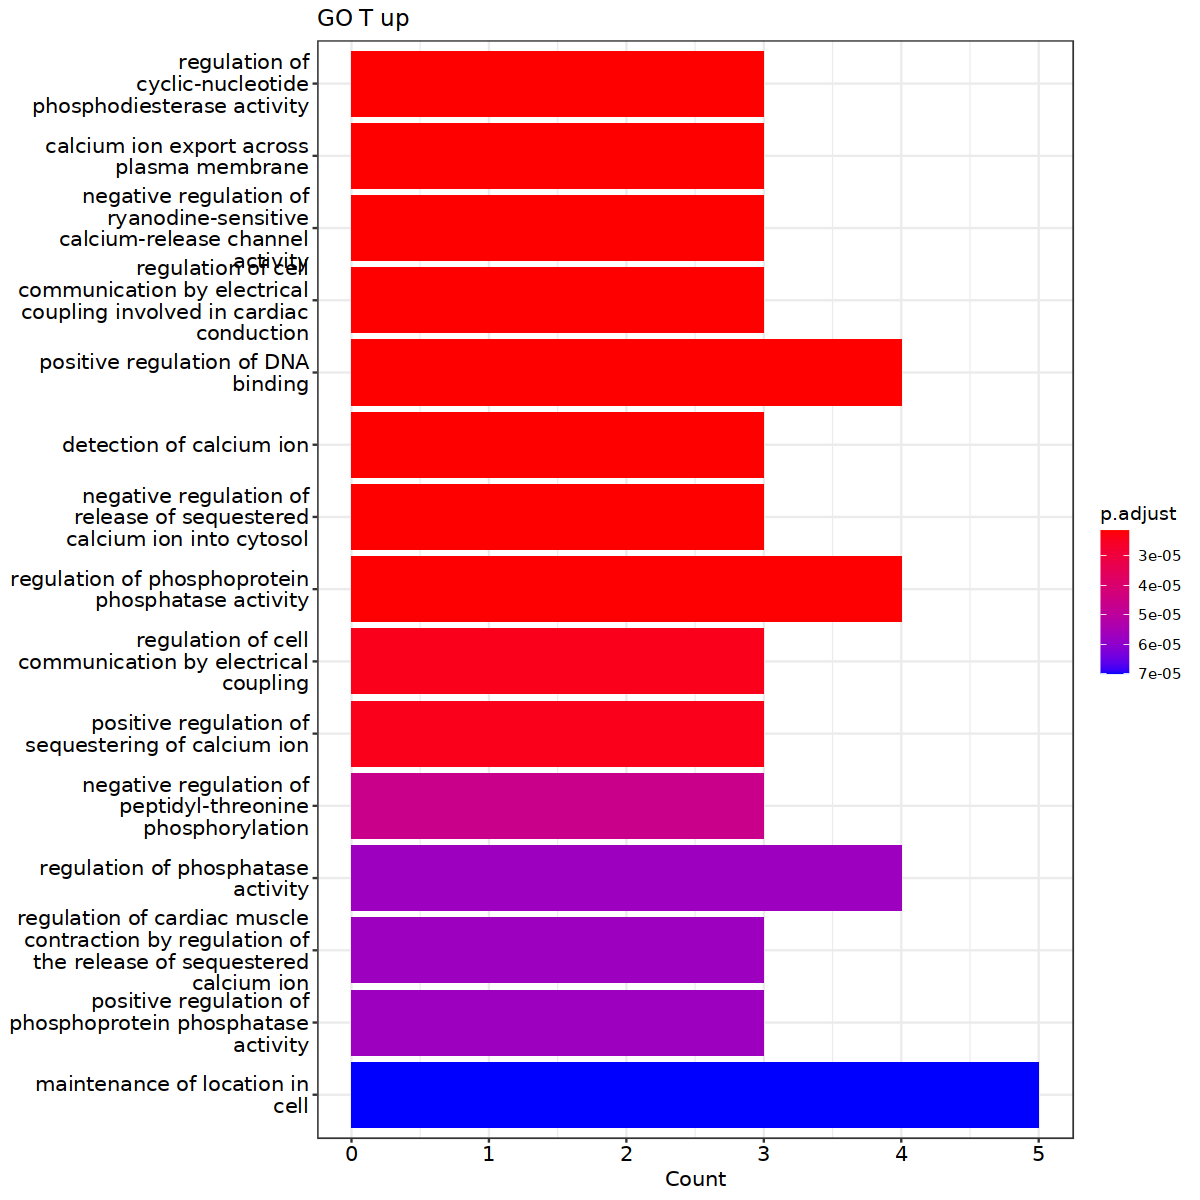

 'table' int [1:134(1d)] 17 9 8 7 7 7 7 6 6 6 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:134] "ITGB1" "SELL" "B2M" "GNAI2" ...
NULL
'data.frame':	99 obs. of  2 variables:
 $ SYMBOL  : chr  "ITGB1" "SELL" "B2M" "GNAI2" ...
 $ ENTREZID: chr  "3688" "6402" "567" "2771" ...
NULL
[1] "B"
[1] "up"
 'table' int [1:13(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:13] "ANXA2" "CALM1" "CALM2" "CALM3" ...
NULL


'select()' returned 1:1 mapping between keys and columns



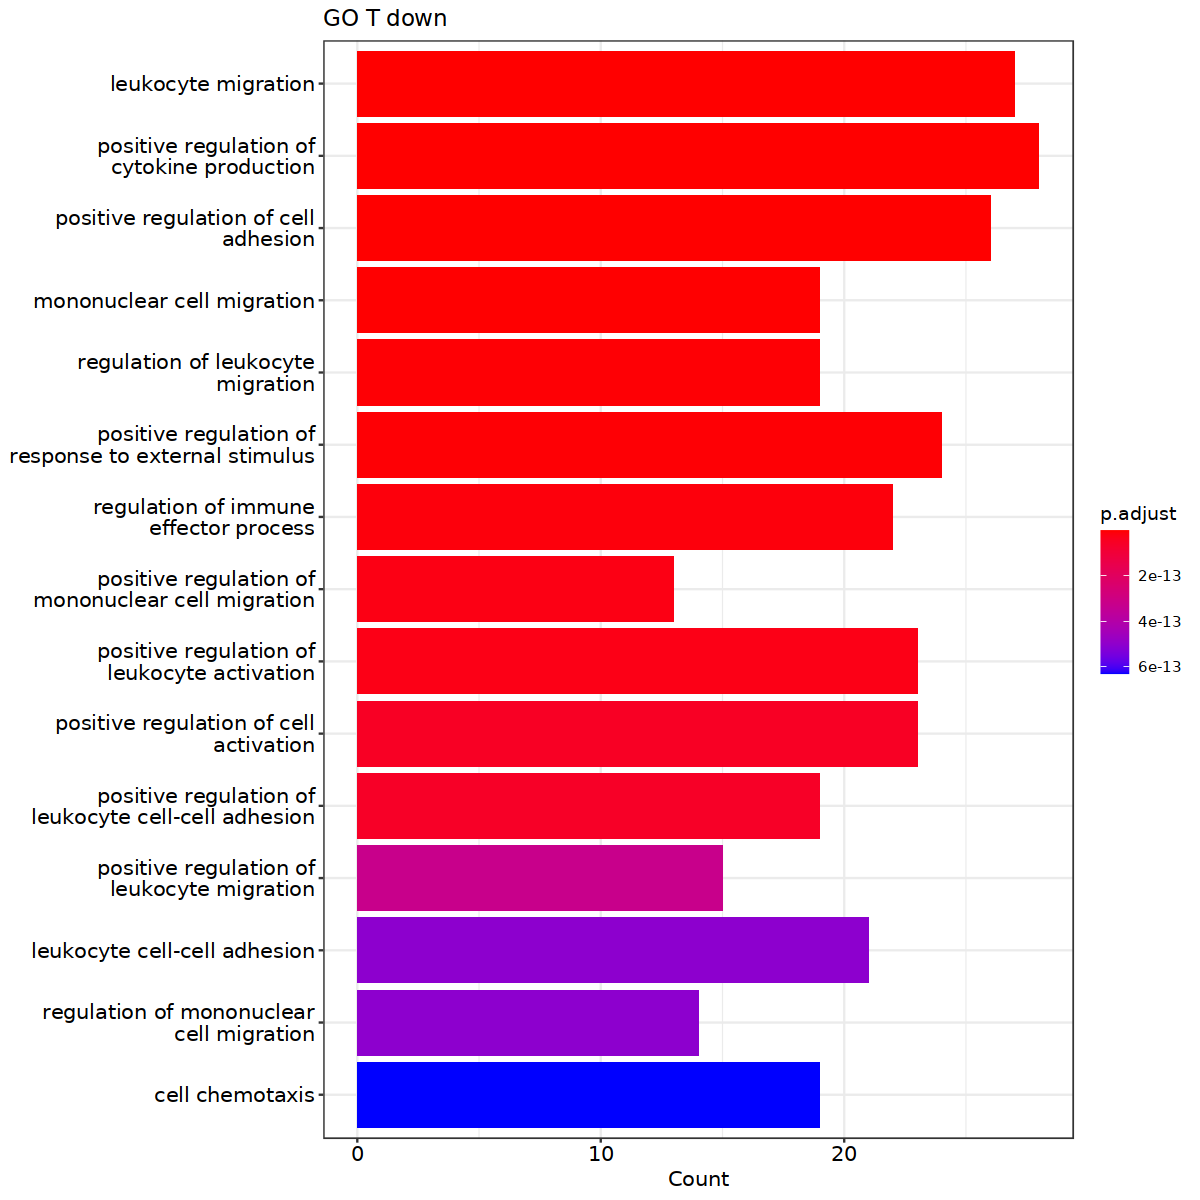

 'table' int [1:13(1d)] 1 1 1 1 1 1 1 1 1 1 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:13] "ANXA2" "CALM1" "CALM2" "CALM3" ...
NULL
'data.frame':	13 obs. of  2 variables:
 $ SYMBOL  : chr  "ANXA2" "CALM1" "CALM2" "CALM3" ...
 $ ENTREZID: chr  "302" "801" "805" "808" ...
NULL
[1] "B"
[1] "down"
 'table' int [1:144(1d)] 28 16 12 11 11 10 10 8 7 7 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:144] "CD9" "APP" "ITGA4" "CD320" ...
NULL


'select()' returned 1:1 mapping between keys and columns



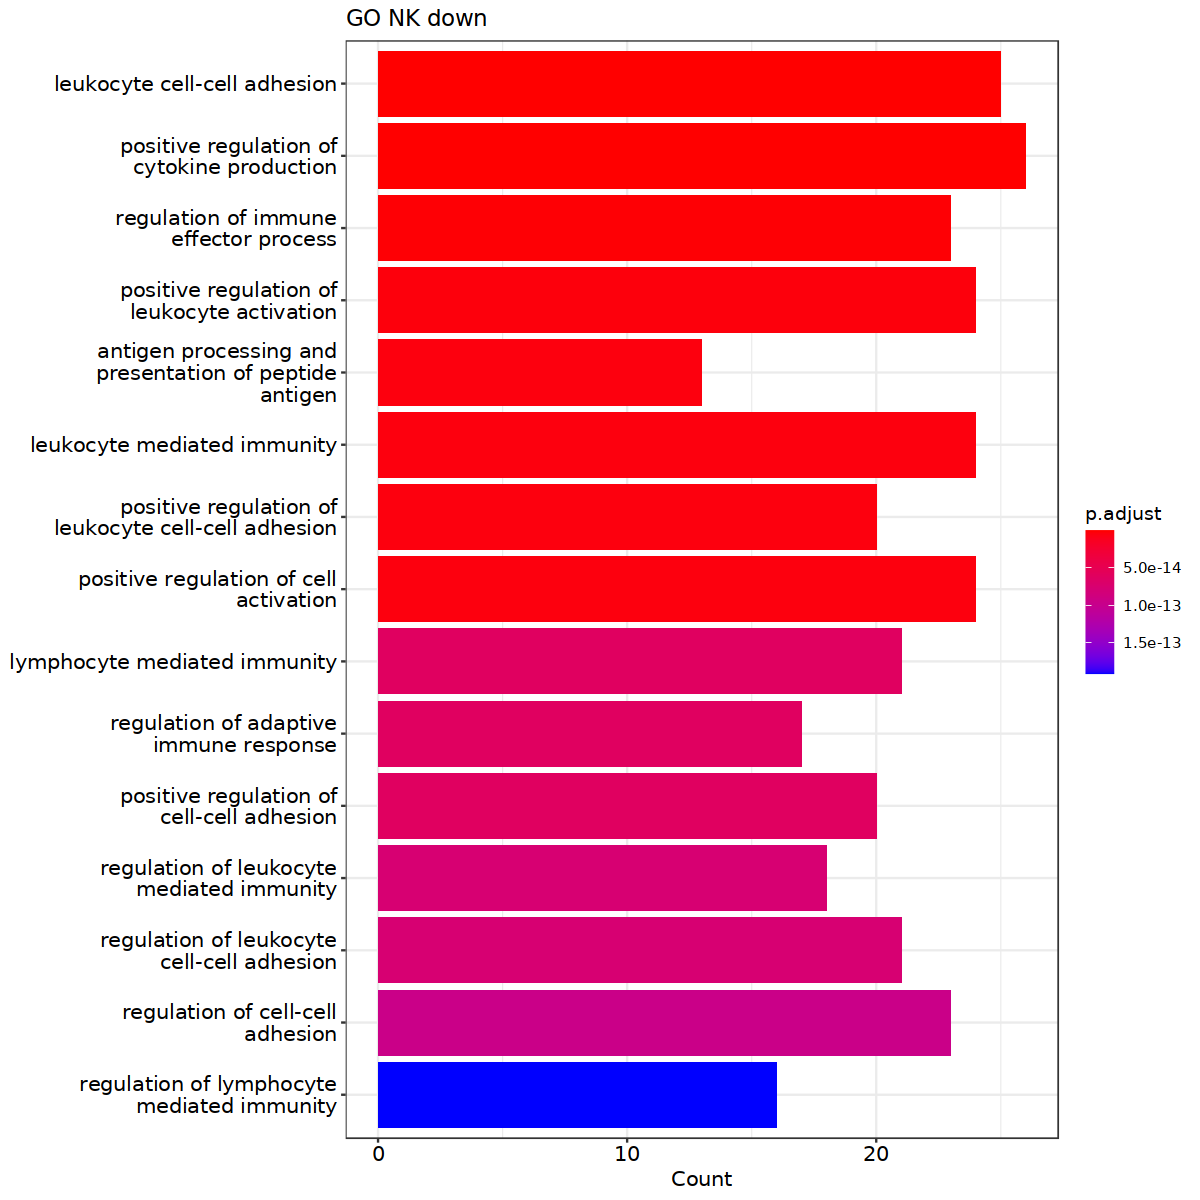

 'table' int [1:144(1d)] 28 16 12 11 11 10 10 8 7 7 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:144] "CD9" "APP" "ITGA4" "CD320" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "CD9" "APP" "ITGA4" "CD320" ...
 $ ENTREZID: chr  "928" "351" "3676" "51293" ...
NULL
[1] "HSPC"
[1] "up"
 'table' int [1:46(1d)] 33 17 10 6 4 4 4 3 3 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:46] "TLR4" "PDE1B" "PLAU" "SIRPA" ...
NULL


'select()' returned 1:1 mapping between keys and columns



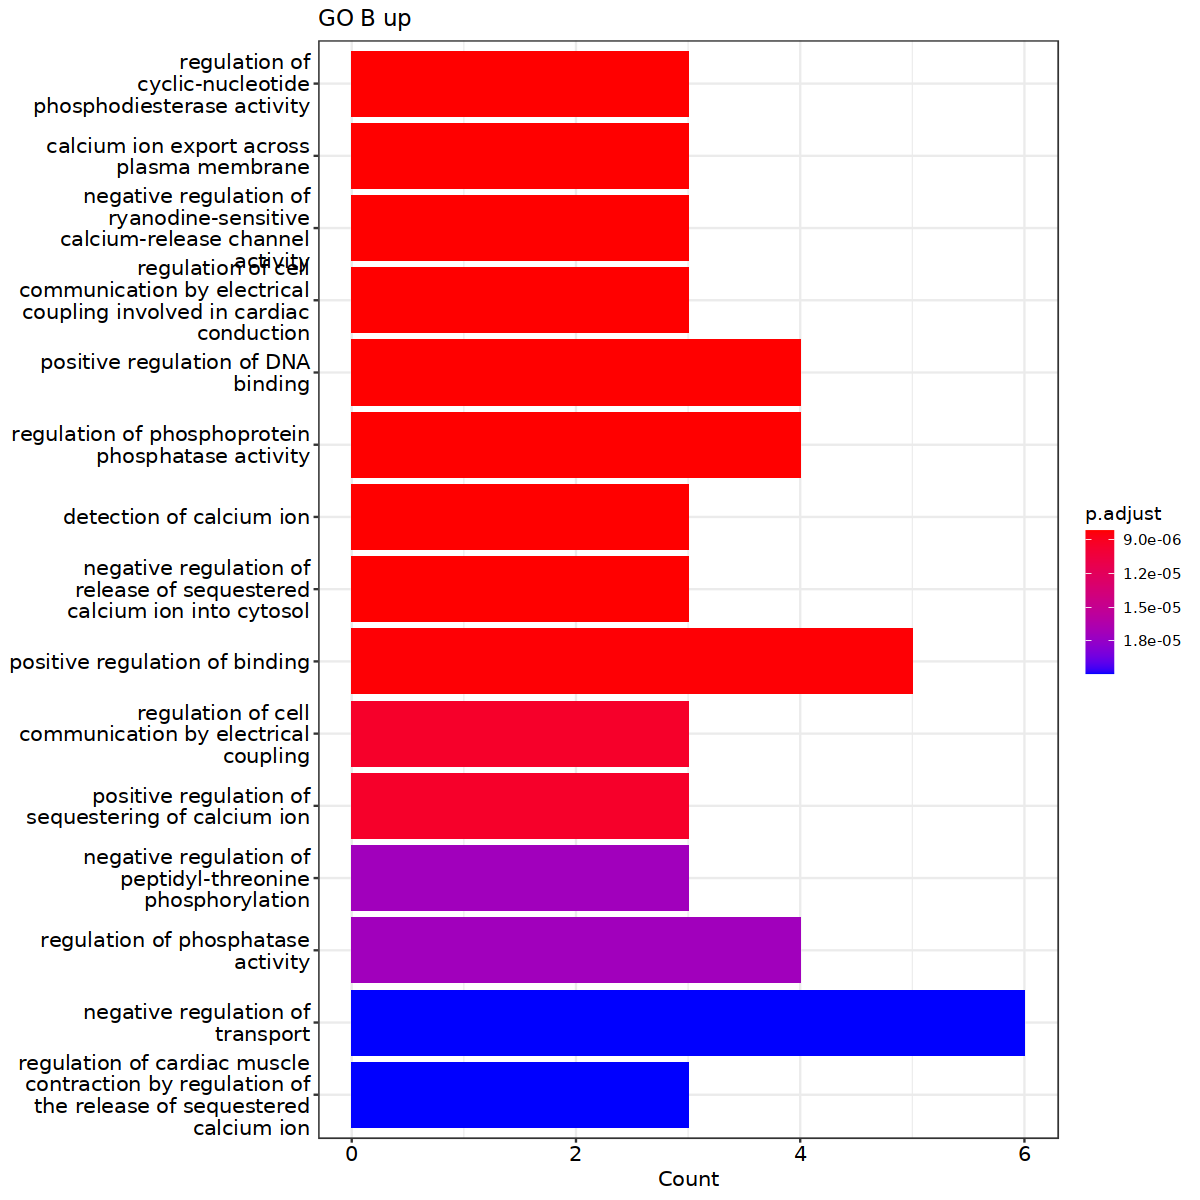

 'table' int [1:46(1d)] 33 17 10 6 4 4 4 3 3 2 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:46] "TLR4" "PDE1B" "PLAU" "SIRPA" ...
NULL
'data.frame':	46 obs. of  2 variables:
 $ SYMBOL  : chr  "TLR4" "PDE1B" "PLAU" "SIRPA" ...
 $ ENTREZID: chr  "7099" "5153" "5328" "140885" ...
NULL
[1] "HSPC"
[1] "down"
 'table' int [1:88(1d)] 26 17 9 8 7 7 7 5 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:88] "ADRA2A" "EPOR" "APOE" "CSF1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



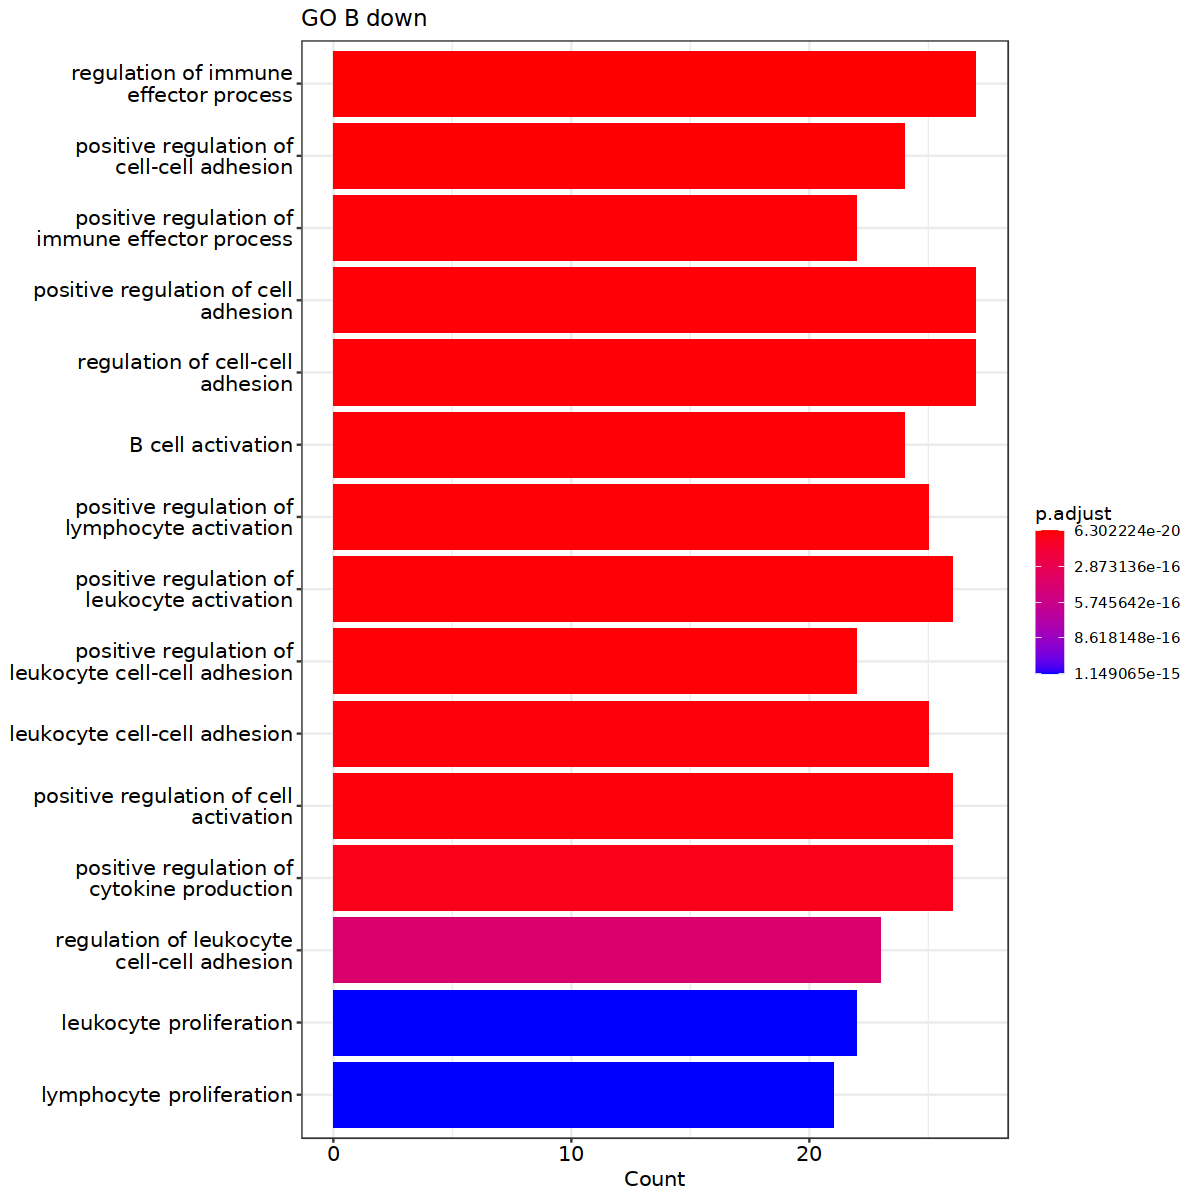

 'table' int [1:88(1d)] 26 17 9 8 7 7 7 5 4 4 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:88] "ADRA2A" "EPOR" "APOE" "CSF1" ...
NULL
'data.frame':	88 obs. of  2 variables:
 $ SYMBOL  : chr  "ADRA2A" "EPOR" "APOE" "CSF1" ...
 $ ENTREZID: chr  "150" "2057" "348" "1435" ...
NULL
[1] "Ery"
[1] "up"
 'table' int [1:4(1d)] 2 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:4] "ADAM10" "IFNAR1" "MTMR4" "MUC1"
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:4(1d)] 2 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:4] "ADAM10" "IFNAR1" "MTMR4" "MUC1"
NULL
'data.frame':	4 obs. of  2 variables:
 $ SYMBOL  : chr  "ADAM10" "IFNAR1" "MTMR4" "MUC1"
 $ ENTREZID: chr  "102" "3454" "9110" "4582"
NULL
[1] "Ery"
[1] "down"
 'table' int [1:166(1d)] 23 21 18 14 13 12 11 11 11 9 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:166] "ITGB1" "ENG" "CD81" "CD320" ...
NULL


'select()' returned 1:1 mapping between keys and columns



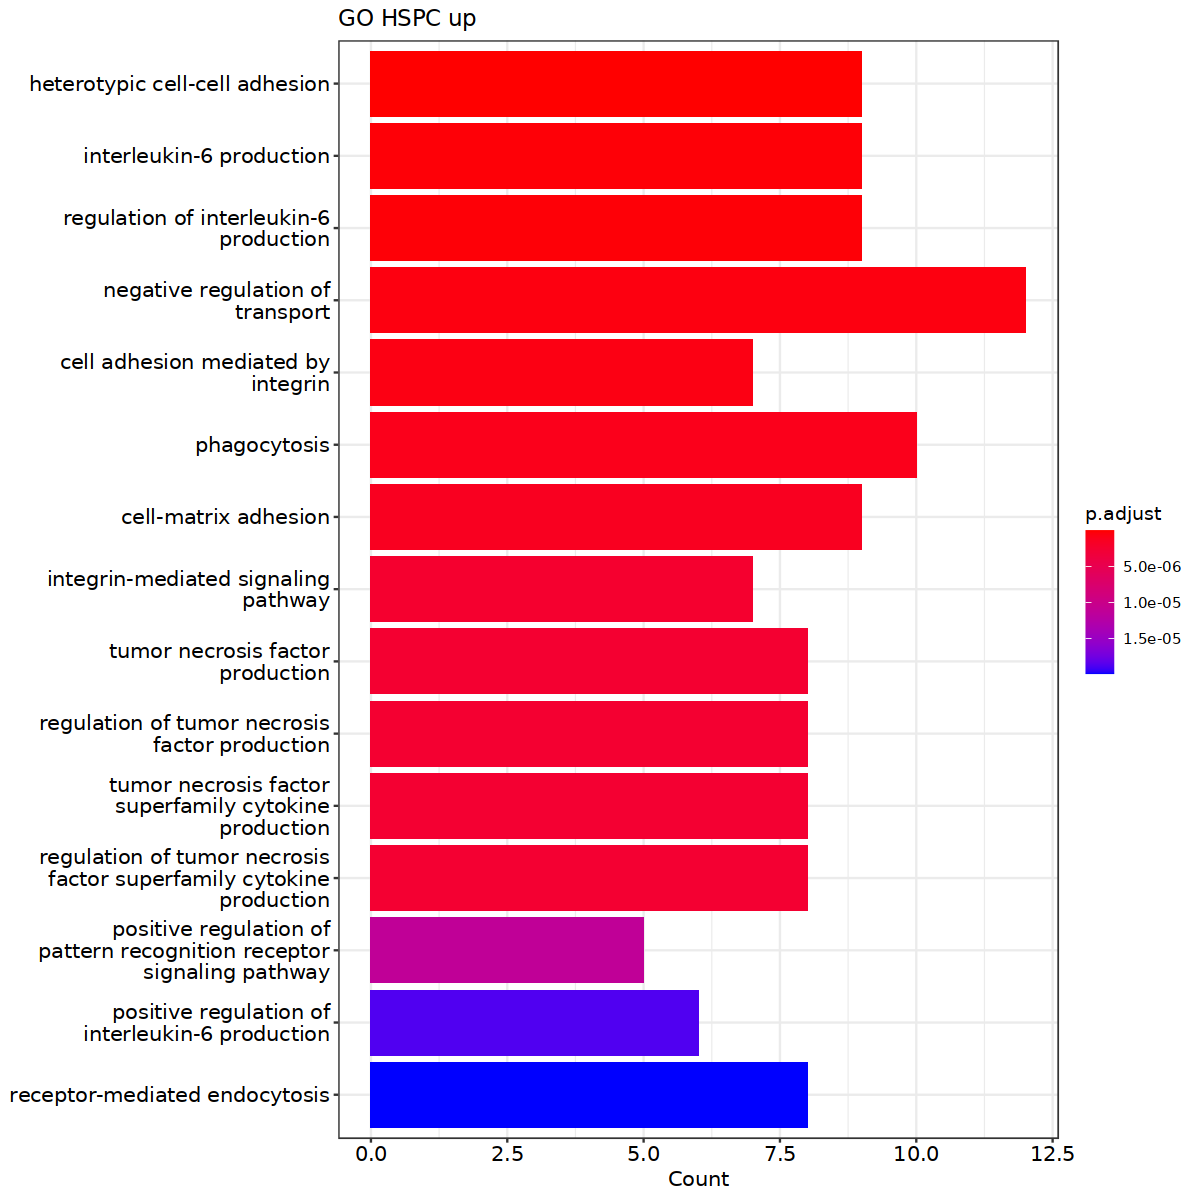

 'table' int [1:166(1d)] 23 21 18 14 13 12 11 11 11 9 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:166] "ITGB1" "ENG" "CD81" "CD320" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "ITGB1" "ENG" "CD81" "CD320" ...
 $ ENTREZID: chr  "3688" "2022" "975" "51293" ...
NULL
[1] "DC"
[1] "up"
 'table' int [1:6(1d)] 5 3 2 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:6] "SIGLEC10" "SORT1" "DUSP18" "CALM1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



 'table' int [1:6(1d)] 5 3 2 1 1 1
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:6] "SIGLEC10" "SORT1" "DUSP18" "CALM1" ...
NULL
'data.frame':	6 obs. of  2 variables:
 $ SYMBOL  : chr  "SIGLEC10" "SORT1" "DUSP18" "CALM1" ...
 $ ENTREZID: chr  "89790" "6272" "150290" "801" ...
NULL
[1] "DC"
[1] "down"
 'table' int [1:313(1d)] 80 54 46 45 37 35 33 32 27 25 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:313] "LRP1" "LILRB2" "APP" "LILRB1" ...
NULL


'select()' returned 1:1 mapping between keys and columns



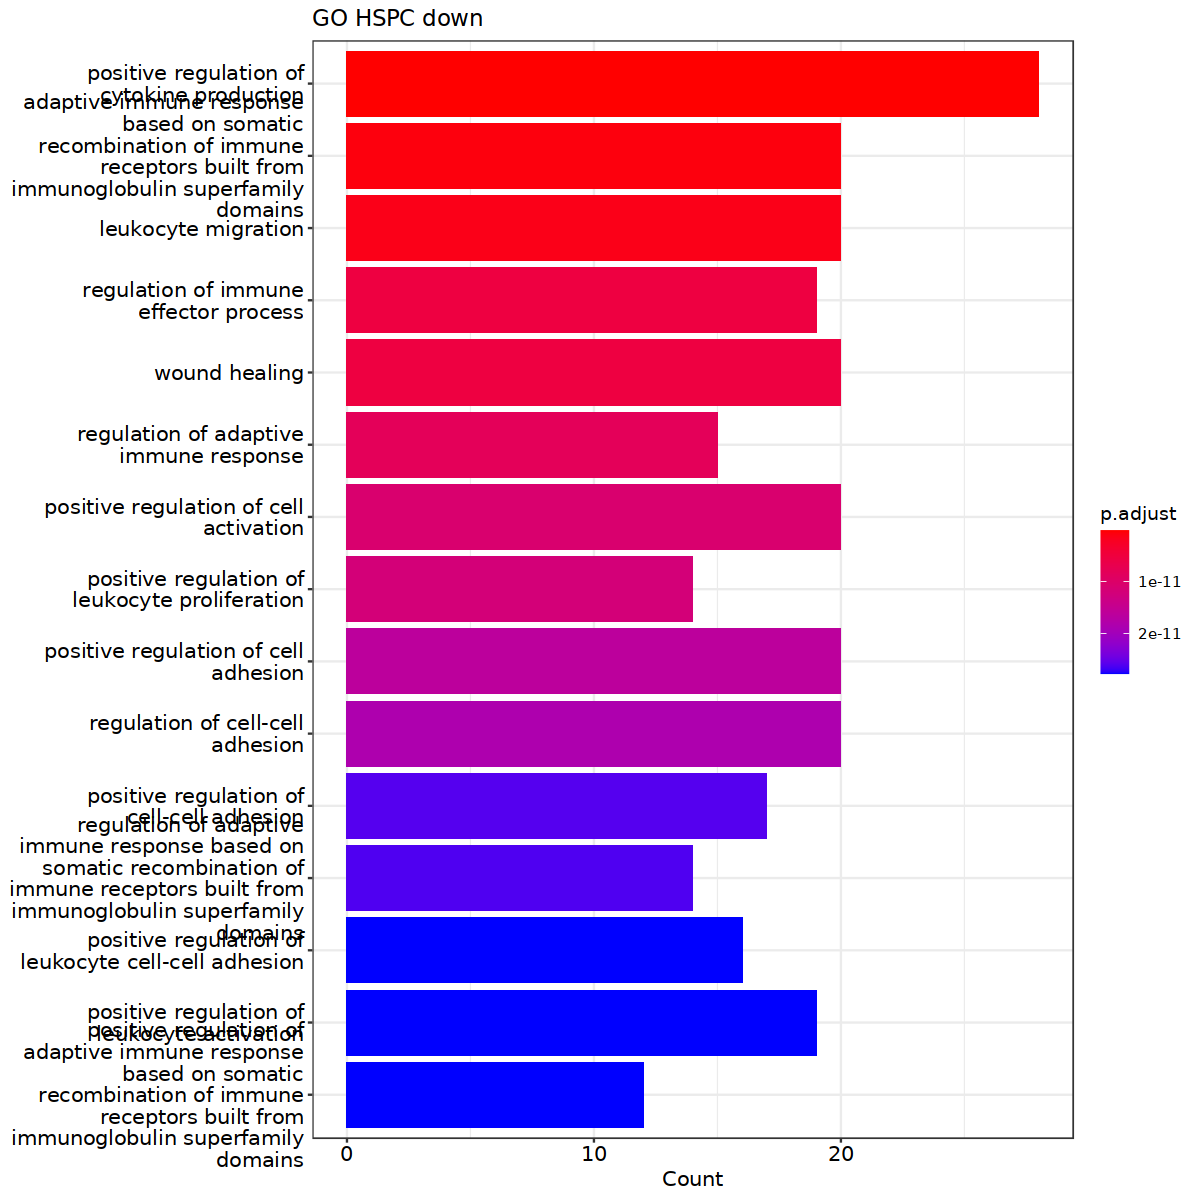

 'table' int [1:313(1d)] 80 54 46 45 37 35 33 32 27 25 ...
 - attr(*, "dimnames")=List of 1
  ..$ : chr [1:313] "LRP1" "LILRB2" "APP" "LILRB1" ...
NULL
'data.frame':	100 obs. of  2 variables:
 $ SYMBOL  : chr  "LRP1" "LILRB2" "APP" "LILRB1" ...
 $ ENTREZID: chr  "4035" "10288" "351" "10859" ...
NULL


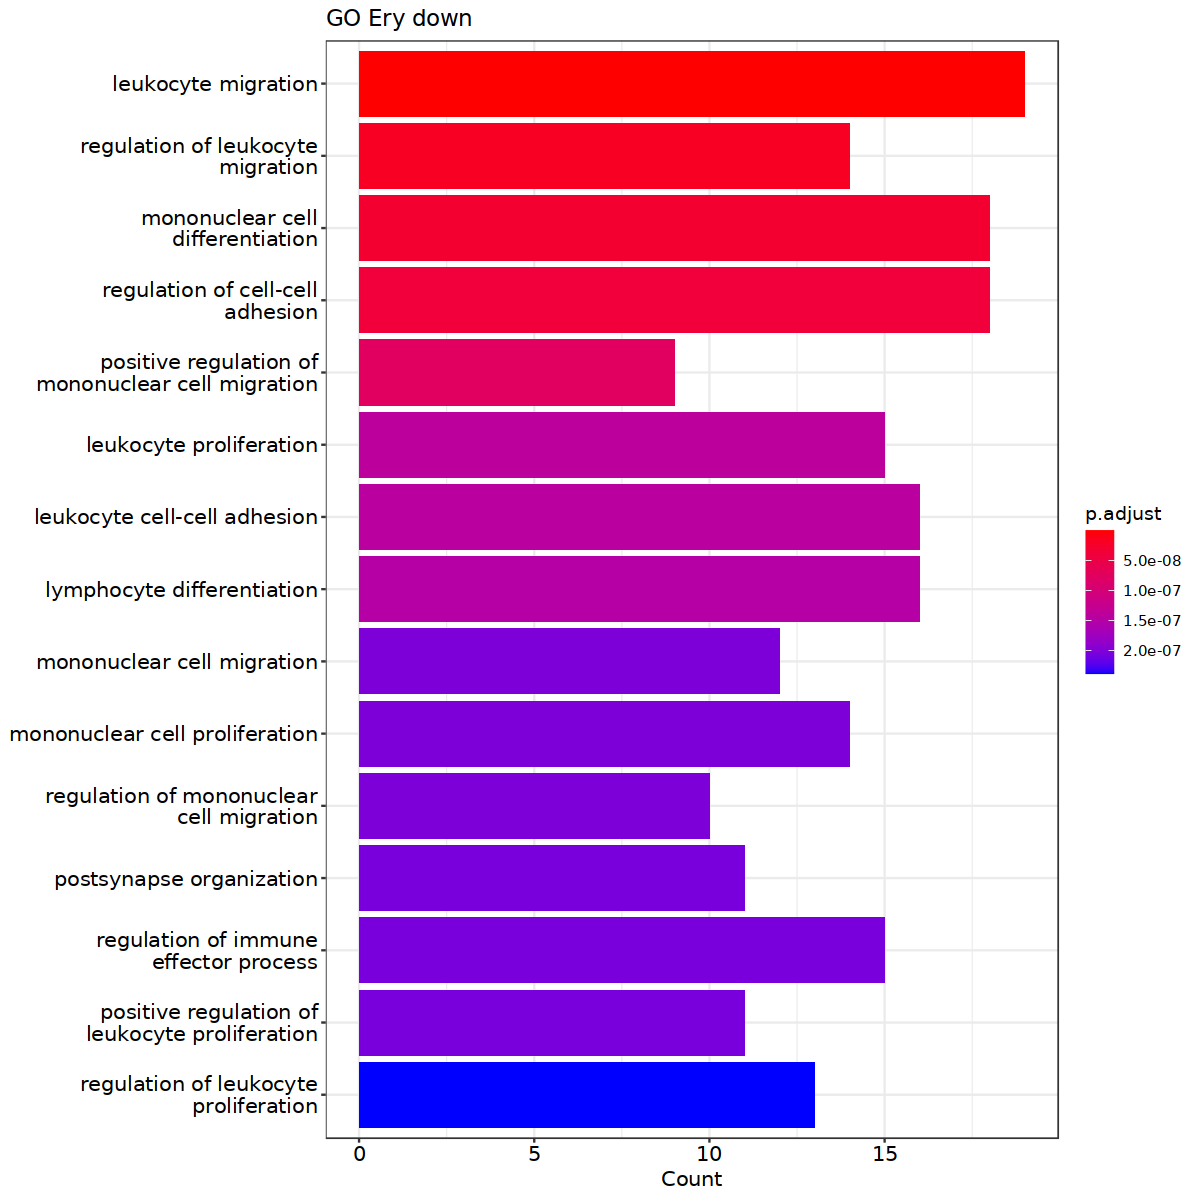

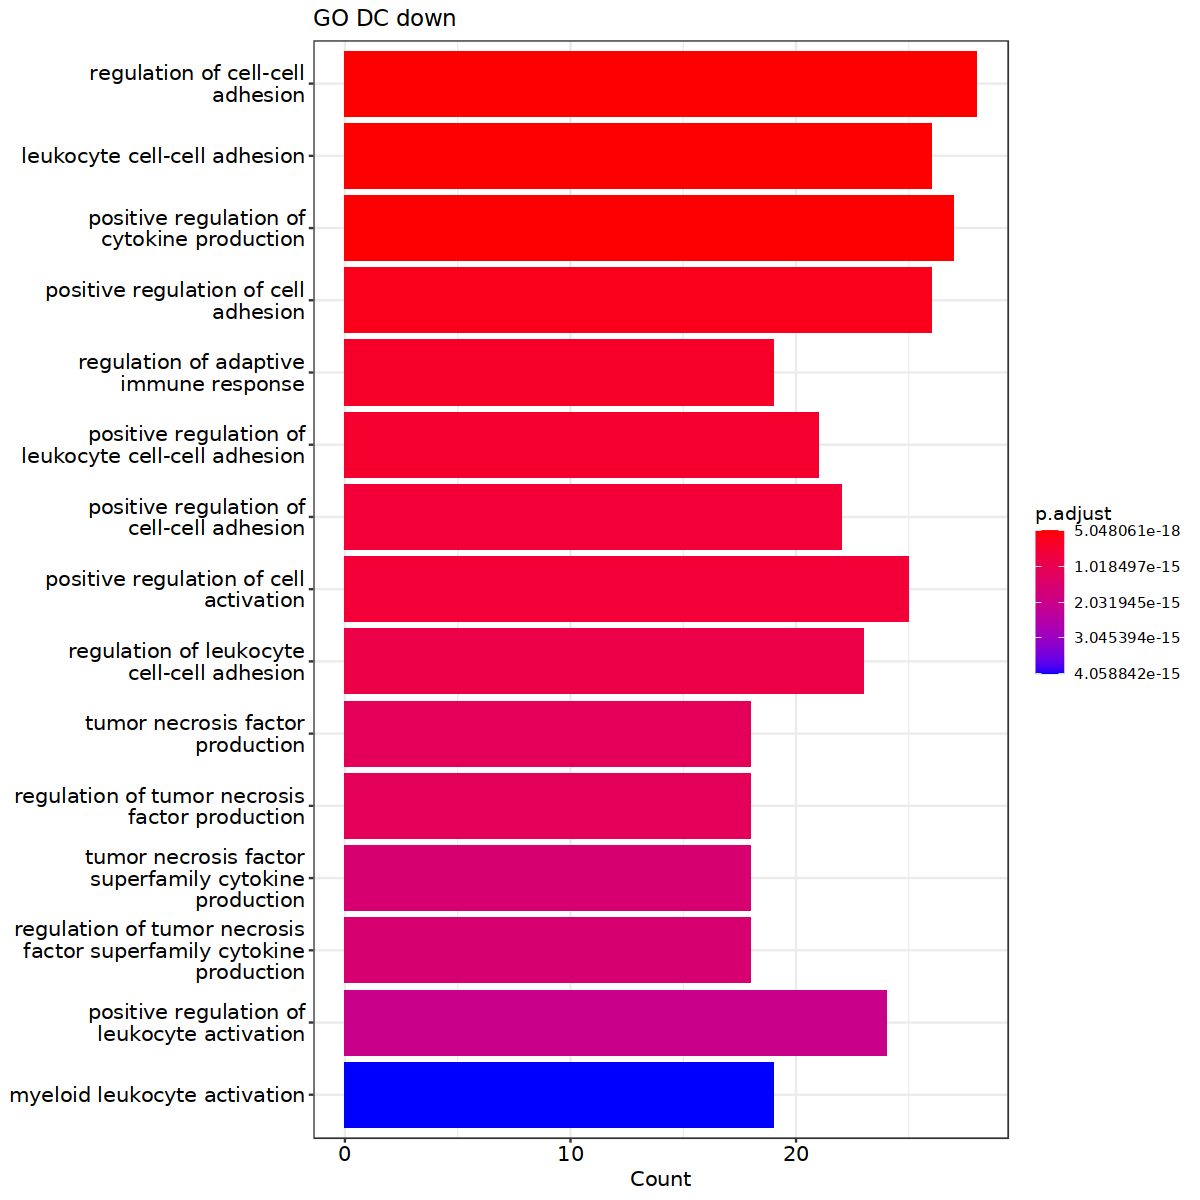

In [67]:
# enrichment of all ligs/rec in down / up-regulated interactions by cell type
options(repr.plot.width = 10
       ,repr.plot.height = 10)
cell_type <- unique(interactions$anno_cells$cell_type)
enrichment <- lapply(cell_type
                     ,function(my_cell_type){
                         
                         idx_sending <- interactions$anno_interactions$sending_cell_type == my_cell_type
                         idx_receiving <- interactions$anno_interactions$receiving_cell_type == my_cell_type
             my_analysis <- lapply(c("up"
                                  ,"down"
                                 )
                                ,function(direction){
                                     print(my_cell_type)
                                    print(direction)
                                    
          ifelse(direction == "up"
                ,idx <- idx_sign & idx_up
                ,idx <- idx_sign & idx_down)
          my_genes <- sort(table(c(interactions$anno_interactions$ligand_gene_name[idx & idx_sending]
                           ,interactions$anno_interactions$receptor_gene_name[idx & idx_receiving]))
                          ,decreasing = TRUE)
          print(str(my_genes))
          if(length(my_genes) != 0){
              ifelse(length(my_genes)< 100
                ,top <- c(1:length(my_genes))
                ,top <- c(1:100))
        genes  <-  AnnotationDbi::select(org.Hs.eg.db, keys=names(my_genes)[top], columns="ENTREZID", keytype="SYMBOL")
        genes  <-  genes[!is.na(genes$ENTREZID),]
        print(str(my_genes))
        print(str(genes))

        #my_background <- unique(c(interactions$anno_interactions$ligand_gene_name[idx_good]
        #                   ,interactions$anno_interactions$receptor_gene_name[idx_good]))
        #background = AnnotationDbi::select(org.Hs.eg.db, keys=my_background, columns="ENTREZID", keytype="SYMBOL")
        #background = background[!is.na(background$ENTREZID),]
        #print(str(my_background))
        #print(str(background))

          a <- lapply(c("GO"
                   #,"KEGG"
                                 )
                 ,function(type_analysis){
                     if(type_analysis == "GO"){
                         BP <- enrichGO(gene = genes$ENTREZID
                                            #,universe = background$ENTREZID
                                            , OrgDb = org.Hs.eg.db
                                            , ont = "BP"
                                            , pAdjustMethod = "BH"
                                            , pvalueCutoff  = 0.01
                                            , qvalueCutoff  = 0.05
                                            , readable = TRUE
                                           )
                         if(sum(unique(BP@result$p.adjust) < 0.01)>0){
                             print(barplot(BP, showCategory=15) + ggtitle(paste(type_analysis,my_cell_type,direction)))
                         }
                        return(BP)
                     } else {
                         kk <- enrichKEGG(gene = genes$ENTREZID
                                            #,universe = background$ENTREZID
                                              ,organism     = 'hsa'
                                              ,pvalueCutoff = 0.05
                                                 )
                        print(barplot(kk, showCategory=15) + ggtitle(paste(type_analysis,my_cell_type,direction)))
                         return(kk)
                     }


          })
              return(a)
              }
                           
      })
                         names(my_analysis) <- c("up", "down")
                         my_analysis
                     })
names(enrichment) <- cell_type
#print(str(enrichment))

In [68]:
print(str(enrichment))

List of 8
 $ Mono:List of 2
  ..$ up  :List of 1
  .. ..$ :Formal class 'enrichResult' [package "DOSE"] with 15 slots
  .. .. .. ..@ result       :'data.frame':	1407 obs. of  9 variables:
  .. .. .. .. ..$ ID         : chr [1:1407] "GO:0051099" "GO:0043388" "GO:0051235" "GO:0051342" ...
  .. .. .. .. ..$ Description: chr [1:1407] "positive regulation of binding" "positive regulation of DNA binding" "maintenance of location" "regulation of cyclic-nucleotide phosphodiesterase activity" ...
  .. .. .. .. ..$ GeneRatio  : chr [1:1407] "7/23" "5/23" "7/23" "3/23" ...
  .. .. .. .. ..$ BgRatio    : chr [1:1407] "177/18903" "57/18903" "342/18903" "10/18903" ...
  .. .. .. .. ..$ pvalue     : num [1:1407] 1.21e-09 6.73e-09 1.14e-07 1.88e-07 1.88e-07 ...
  .. .. .. .. ..$ p.adjust   : num [1:1407] 1.70e-06 4.73e-06 4.03e-05 4.03e-05 4.03e-05 ...
  .. .. .. .. ..$ qvalue     : num [1:1407] 8.22e-07 2.28e-06 1.95e-05 1.95e-05 1.95e-05 ...
  .. .. .. .. ..$ geneID     : chr [1:1407] "ANXA2/CALM1/C

 chr [1:15, 1:8] "myeloid leukocyte activation" ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:8] "Mono" "Gran" "T" "NK" ...
NULL
 chr [1:51] "myeloid leukocyte activation" ...
NULL


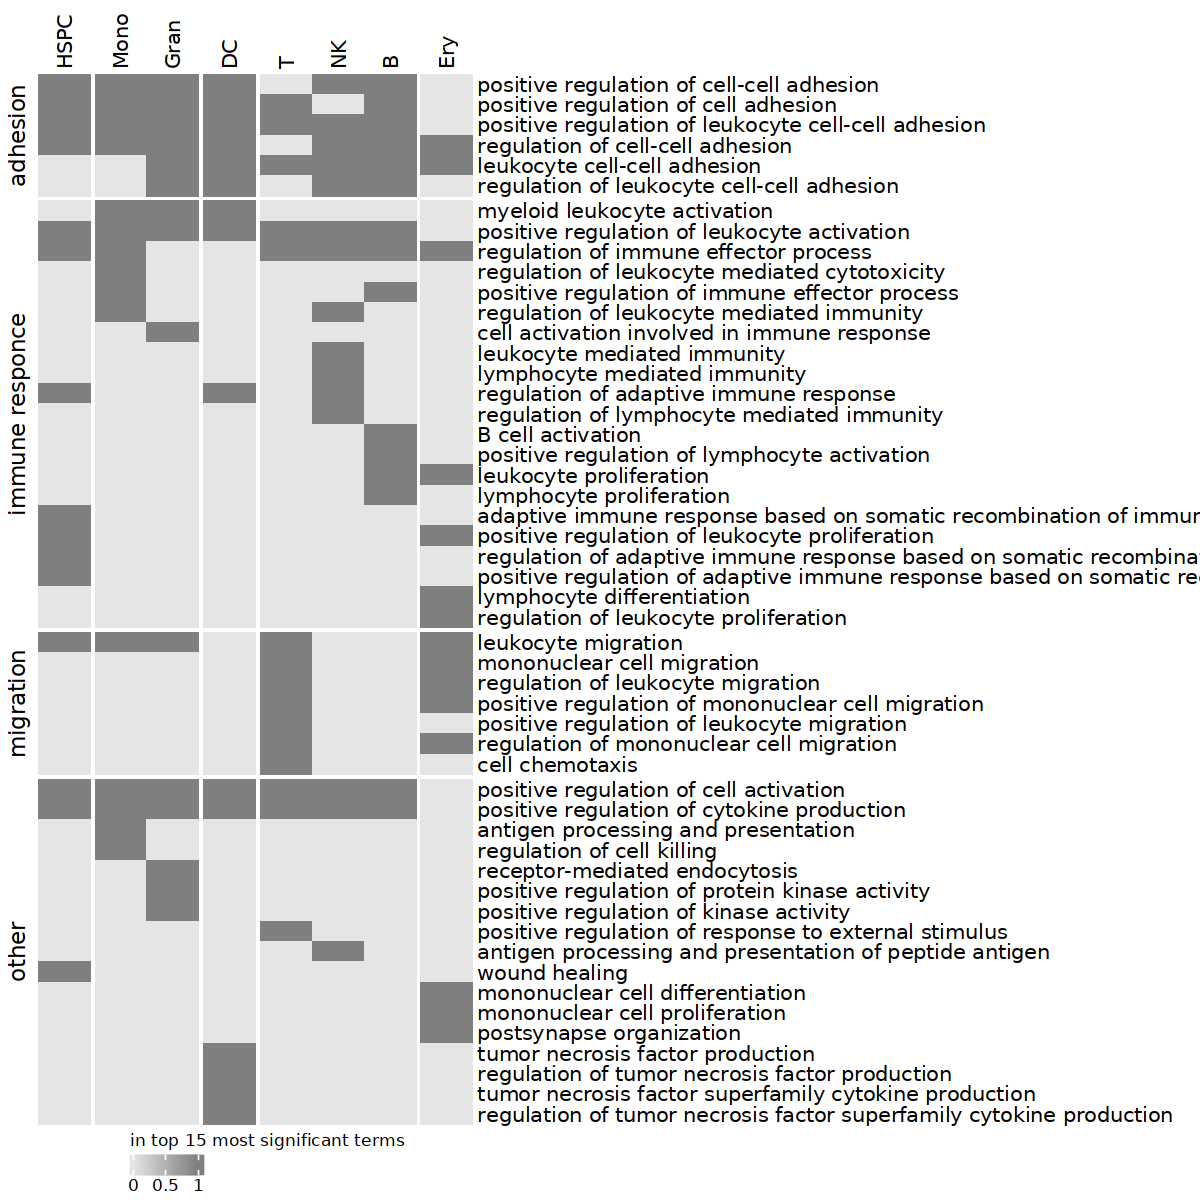

In [69]:
# extract top 15 most significant terms for down interaction for each cell type
top_downregulated <- sapply(cell_types
                           ,function(my_cell_type){
                               my_GO <- enrichment[[my_cell_type]]$down[[1]]@result
                               idx_sign <- my_GO$p.adjust < 0.01
                               return(my_GO$Description[idx_sign][1:15])
                           })
print(str(top_downregulated))

union <- unique(c(top_downregulated))
print(str(union))

# define classes of interactions
idx_adhesion <- grepl("adhesion",union)
#print("adhesion:")
#print(union[idx_adhesion])
idx_migration <- grepl("migration", union) | grepl("chemotaxis", union)
#print("")
#print("migration:")
#print(union[idx_migration])
idx_immune <- grepl("immune"
                    , union) | grepl("immunty"
                                     , union) | grepl("leukocyte"
                                                      , union) & (!idx_adhesion) & (!idx_migration) | grepl("B cell"
                                                                      ,union) | grepl("T cell"
                                                                                     ,union) | grepl("lymphocyte"
                                                                                                    ,union) 
#print("")
#print("immune:")
#print(union[idx_immune])
idx_rest <- !(idx_adhesion | idx_migration | idx_immune)
#print("")
#print("rest:")
#print(union[idx_rest])

summary <- as.data.frame(matrix(,nrow = length(union)
                               ,ncol = length(cell_types)))
rownames(summary) <- union
colnames(summary) <- cell_types
for(my_cell_type in cell_types){
    summary[,my_cell_type] <- rownames(summary) %in% top_downregulated[,my_cell_type]
}
#print(str(summary))
row_split <- c(rep("adhesion"
                  ,sum(idx_adhesion)
                  )
               ,rep("migration"
                   ,sum(idx_migration)
                   )
               ,rep("immune responce"
                   ,sum(idx_immune)
                   )
               ,rep("other"
                   ,sum(idx_rest))
              )
union_sorted <- c(union[idx_adhesion]
                           ,union[idx_migration]
                           ,union[idx_immune]
                           ,union[idx_rest])

names(row_split) <- union_sorted
#print(row_split)

summary <- summary[union_sorted,c("HSPC","Mono", "Gran", "DC", "T","NK", "B", "Ery")]

my_color <-  colorRamp2(seq(0,1, length = 2)
                            , c("gray90", "gray50"))
idx_highlighted <- grepl("B cell", union_sorted) | grepl("lymphocyte", union_sorted) | grepl("T cell",union_sorted) | grepl("myeloid", union_sorted)
highlight_fonts <- sapply(idx_highlighted, function(i) ifelse(i, "bold", "plain"))

h <- Heatmap(as.matrix(summary*1)
             ,column_order = c("HSPC","Mono", "Gran", "DC", "T","NK", "B", "Ery")
             ,column_names_side = "top"
             ,column_split = c(1,2,2,3,4,4,4,5)
             ,column_title=NULL
             #,column_names_rot = 90
             ,col = my_color
             ,row_split = row_split
             ,row_names_gp = gpar(fontface = highlight_fonts)
             ,cluster_rows = FALSE
            ,heatmap_legend_param = list(direction = "horizontal")
             ,row_names_max_width = unit(15, "cm")
             ,name="in top 15 most significant terms"
            )
ComplexHeatmap::draw(h
                    ,heatmap_legend_side = "bottom")

# Export

In [71]:
print("save interactions.RData")
save(interactions, file = "interactions.RData")

[1] "save interactions.RData"
